In [1]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from PXPY import *
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
import GETFF
from joblib import Parallel, delayed
import importlib
from scipy.optimize import curve_fit
#importlib.reload(ASYMMETRY)

Welcome to JupyROOT 6.26/06


In [2]:
###############################################################################
###############################################################################

#NEEDS INELASTIC ASYMMETRY, NITROGEN CONTAMINATION

###############################################################################
###############################################################################

In [3]:
Pass="2"
config="2"
generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3/final_2_{1}.npz")


In [4]:
W2min=CONFIG.Function_JSON("W2min",f"../config/Pass{Pass}/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/Pass{Pass}/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/Pass{Pass}/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/Pass{Pass}/cuts{config}.cfg")
hcalmin=CONFIG.Function_JSON("hcalmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/Pass{Pass}/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/Pass{Pass}/cuts{config}.cfg")

#  "dxmin"	: -0.481,
#  "dxmax"	: 0.498, old gen2


print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'hcalmin: {hcalmin}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Q2: {Q2}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

#W2min=-1.9
#dymin=-1
#W2max=2

W2min: 0
W2max: 1.5
dxmin: -0.8
dxmax: 0.8
dymin: -0.822
dymax: 0.8
hcalmin: 0.025
dybgmin: -1.4
dybgmax: 1.4
Q2: 3
Coin Min: 123 Coin Max: 134


In [5]:

new_coinmin=coinmin+6.5-6/2
new_coinmax=coinmax-5.5+6/2

In [6]:
new_coinmin

126.5

In [7]:
new_coinmax

131.5

In [8]:
#in GeV^2
m=.939565
Mp=.938
muN=-1.9103
mup=2.793

if config=="2":
    Q2=3
    tau=Q2/(4*m**2)
    theta=29.5*pi/180
if config=="3":
    Q2=6.83
    #Q2=6.62 #seans number
    tau=Q2/(4*m**2)
    theta=36.5*pi/180
if config=="4":
    Q2=9.82
    tau=Q2/(4*m**2)
    theta=35*pi/180

# Target Spin Direction

In [9]:
if config=="2":
    spintheta=59.34
    spinphi=1.84
if config=="3":
    spintheta=70.94
    spinphi=.51
if config=="4":
    spintheta=74.07
    spinphi=.55





In [10]:

fileNum=1
simconfig=config
if config=="4a" or config=="4b":
    simconfig="4"
genericSim=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN{simconfig}/simulation0.npz")
genericSimIN=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN2/insimulationNEW0.npz")

print(genericSim.files)
print(genericSimIN.files)



['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'ephi', 'trP', 'fnucl', 'weight', 'eHCAL']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP', 'fnucl', 'weight', 'mc_sig', 'mc_sigOld', 'mc_sigPol', 'mc_BETA', 'mc_THETA']


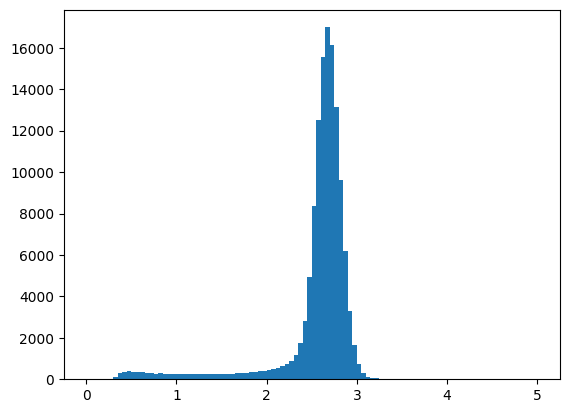

In [11]:
d=plt.hist(genericSim["trP"],bins=100,range=(0,5))

In [12]:
#%load_ext memory_profiler
#%memit doit()


In [13]:
dataTarget = pd.read_csv('../DB/ProcessedHe3Pol.csv')
dataBeam = pd.read_csv('../DB/ProcessedBeamPol.csv')
target_run_num = dataTarget['Run Number'].to_numpy()
target_pol = dataTarget['Polarization'].to_numpy()
target_polE=dataTarget['Error'].to_numpy()
beam_run_num = dataBeam['Run Number'].to_numpy()
beam_pol = dataBeam['Polarization'].to_numpy()
beam_polE=dataBeam['Error'].to_numpy()

In [14]:
target_pol/100

array([0.33784094, 0.34959488, 0.35102284, ..., 0.40446772, 0.34115021,
       0.22716826])

In [15]:
target_polE/100

array([0.01700711, 0.01762116, 0.01779658, ..., 0.01687292,        nan,
              nan])

In [16]:
print("hehe")

hehe


In [17]:
%%time
if(len(generic["dx"])<3000000):
    
    useGrinch=False

    
    genericMaster = {}
    base_dir = f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3"
    i = 0
    print(f"NumPy array directory = {base_dir}")
    while os.path.exists(f"{base_dir}/final_2_{i}.npz"):
        print(f"Loading in file {i}")
        if i>5:            #GPS
            break            #GPS
        file_path = f"{base_dir}/final_2_{i}.npz"
        data = np.load(file_path)

        cut=(data["ePS"]>0.2)
        if Pass=="2":
            grinchcut=(data["grinch_clus_size"]>=2)&(data["grinch_clus_trackindex"]==0)
            antigrinchcut=(data["grinch_clus_size"]<2)|(data["grinch_clus_trackindex"]!=0)
            pscut=(data["ePS"]>0) #GPS
            bbcalE=data["eSH"]+data["ePS"]
            gemP=data["trP"]
            
            epcut=bbcalE/gemP>.7 #GPS
            pscut=(data["ePS"]>0.2)
            pscut=(data["ePS"]>0)
            if useGrinch:
                print("using grinch cut")
                #cut=antigrinchcut  #ANTIG
                cut=grinchcut
            else:
                print("using ps cut")
                cut=pscut#&epcut
        for key in data.files:
            if key not in genericMaster:
                cut_data = data[key][cut]
                genericMaster[key] = cut_data

            else:
                cut_data = data[key][cut]
                genericMaster[key] = np.concatenate((genericMaster[key], cut_data))

        data.close()
        i += 1

    print(f"Loaded {i} files into genericMaster.")


NumPy array directory = /media/research/TOSHIBA EXT/GEn/NumpyData/Pass2/GEN2/He3
Loading in file 0
using ps cut
Loading in file 1
using ps cut
Loading in file 2
using ps cut
Loading in file 3
using ps cut
Loading in file 4
using ps cut
Loading in file 5
using ps cut
Loading in file 6
Loaded 6 files into genericMaster.
CPU times: user 4.75 s, sys: 5.72 s, total: 10.5 s
Wall time: 35.1 s


In [18]:
generic=genericMaster

In [20]:
new_W2min=.87-8/10
new_W2max=.88+8/20
new_dxmin=-.1-17/20
new_dxmax=.1+17/20
new_dymin=-.1-6/10
new_dymax=.1+6/10
psmin=.2
epmin=.7
new_coinmin=coinmin+6.5-7/2
new_coinmax=coinmax-6.5+7/2

new_W2min=.87-8/10
new_W2max=1.5#.88+8/20
new_dxmin=-.1-17/20
new_dxmax=.1+17/20
new_dymin=-.1-6/10
new_dymax=.1+6/10
psmin=.2
epmin=.7
new_coinmin=coinmin+6.5-7/2
new_coinmax=coinmax-6.5+7/2


Text(0.5, 1.0, 'GEN2')

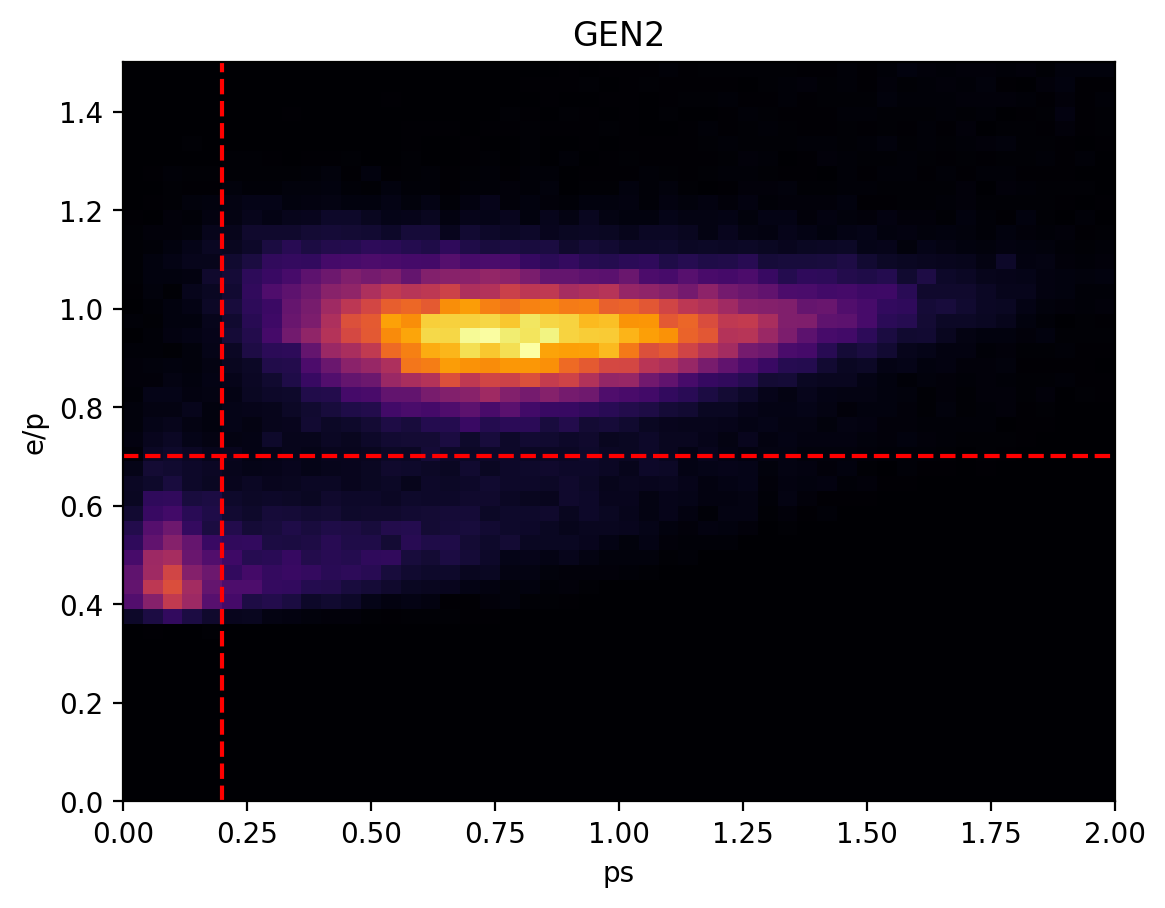

In [21]:
bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]
plt.figure(dpi=200)

wcut=(generic["W2"] < new_W2max)&(generic["W2"]>new_W2min) 
dycut=(generic["dy"]<new_dymax)&(generic["dy"]>new_dymin) 
dxcut=(generic["dx"] < new_dxmax)&(generic["dx"]>new_dxmin) 
coincut=(new_coinmin < generic["coin_time"])&(generic["coin_time"] < new_coinmax)
fullcut=wcut  &dycut & dxcut #& coincut
d=plt.hist2d(generic["ePS"][fullcut],bbcalE[fullcut]/gemP[fullcut],
             bins=(50,50),range=((0,2),(0,1.5)),cmap='inferno')
plt.axhline(.7,color="red",linestyle="--")
plt.axvline(.2,color="red",linestyle="--")
#plt.axhline(1.05)
plt.ylabel("e/p")
plt.xlabel("ps")
plt.title("GEN2")

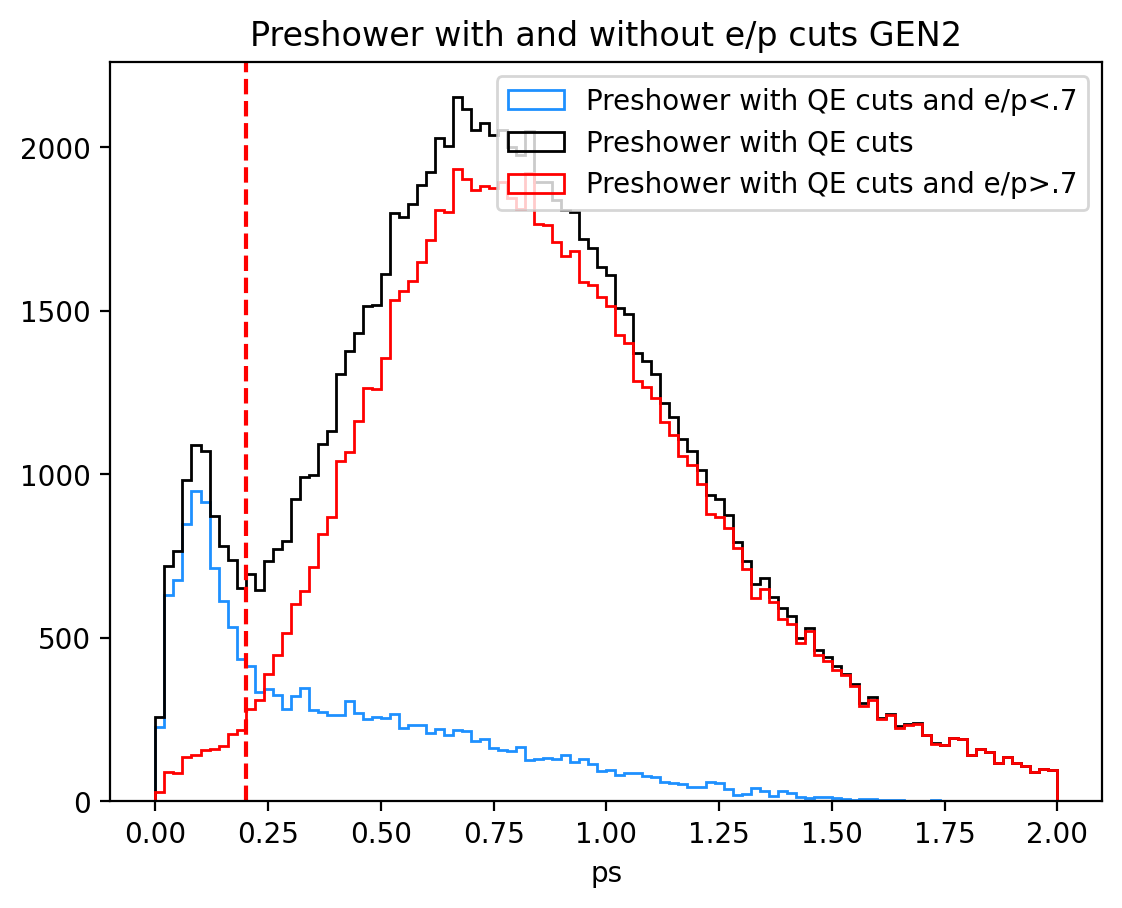

In [22]:
epcut=bbcalE/gemP>.7
plt.figure(dpi=200)

d=plt.hist(generic["ePS"][fullcut&~epcut],color='dodgerblue',
           label='Preshower with QE cuts and e/p<.7',histtype='step',bins=100,range=(0,2))
d=plt.hist(generic["ePS"][fullcut],histtype='step',color='black',
           label='Preshower with QE cuts',bins=100,range=(0,2))
d=plt.hist(generic["ePS"][fullcut&epcut],histtype='step',color='red',
           label='Preshower with QE cuts and e/p>.7',bins=100,range=(0,2))
plt.title("Preshower with and without e/p cuts GEN2")
plt.xlabel("ps")
plt.axvline(.2,color="red",linestyle="--")

plt.legend(loc='upper right')

# Cuts

### Making the correct helicity

In [21]:


IHWP_IN=np.where(generic["IHWP"]==1)
helicity=generic["helicity"]
helicity[IHWP_IN]*=-1


### Cuts for data, bgsim, np sim 

In [22]:
bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]

wcut=(generic["W2"] < new_W2max)&(generic["W2"]>new_W2min) 
dycut=(generic["dy"]<new_dymax)&(generic["dy"]>new_dymin) 
dxcut=(generic["dx"] < new_dxmax)&(generic["dx"]>new_dxmin) 
coincut=(new_coinmin < generic["coin_time"])&(generic["coin_time"] < new_coinmax)
epcut=bbcalE/gemP>.7
pscut=generic["ePS"]>.2
runnumcut=generic["runnum"]>2165

fullcut=wcut & dycut & dxcut & coincut&epcut&runnumcut&pscut
fullcutfordx=wcut&dycut&coincut&epcut&runnumcut

accidentalcut=wcut&dycut&dxcut&epcut&runnumcut


anticoincut=(coinmin-8 > generic["coin_time"])|(generic["coin_time"] > coinmax+5)

hpluscut=helicity==-1 # opposite for kin2
hminuscut=helicity==1

bgcut=(genericSimIN["W2"] < W2max)&(genericSimIN["W2"]>W2min)
antibgcut=(abs(generic["dy"])>1.2)&wcut&coincut
antibgAcut=(abs(generic["dy"])>2)&wcut&coincut

Simwcut=(genericSim["W2"] < W2max)&(genericSim["W2"]>W2min) 
Simdycut=(abs(genericSim["dy"]) < 0.5) 
Simdxcut=(genericSim["dx"] < dxmax)&(genericSim["dx"]>dxmin) 
Simfullcut=Simwcut & Simdycut & Simdxcut

InSimdxcut=(genericSimIN["dx"] < dxmax)&(genericSimIN["dx"]>dxmin)
InSimdycut=(genericSimIN["dy"] < dymax)&(genericSimIN["dy"]>dymin)

protoncut=genericSim["fnucl"]==1
neutroncut=genericSim["fnucl"]==0
weight=genericSim["weight"]



sigma=genericSimIN["mc_sig"]
sigmaold=genericSimIN["mc_sigOld"]
sigmapol=genericSimIN["mc_sigPol"]
THETA=genericSimIN["mc_THETA"]
BETA=genericSimIN["mc_BETA"]
Q2_in=genericSimIN["Q2"]
nu_in=genericSimIN["nu"]
W2_in=genericSimIN["W2"]
x_in  = Q2_in/(2.0*Mp*nu_in)
dy_in=genericSimIN["dy"]
dx_in=genericSimIN["dx"]

dy_incut=(dy_in<dymax)&(dy_in>dymin)
bgcut=(W2_in<W2max)&(W2_in>W2min)#&(abs(dy_in) < 0.5)#&(sigma<1e-39)##&(Q2<6.1)#
sigmacut=(sigma>6e-39)
goodsigmacut=sigma<.4e-37

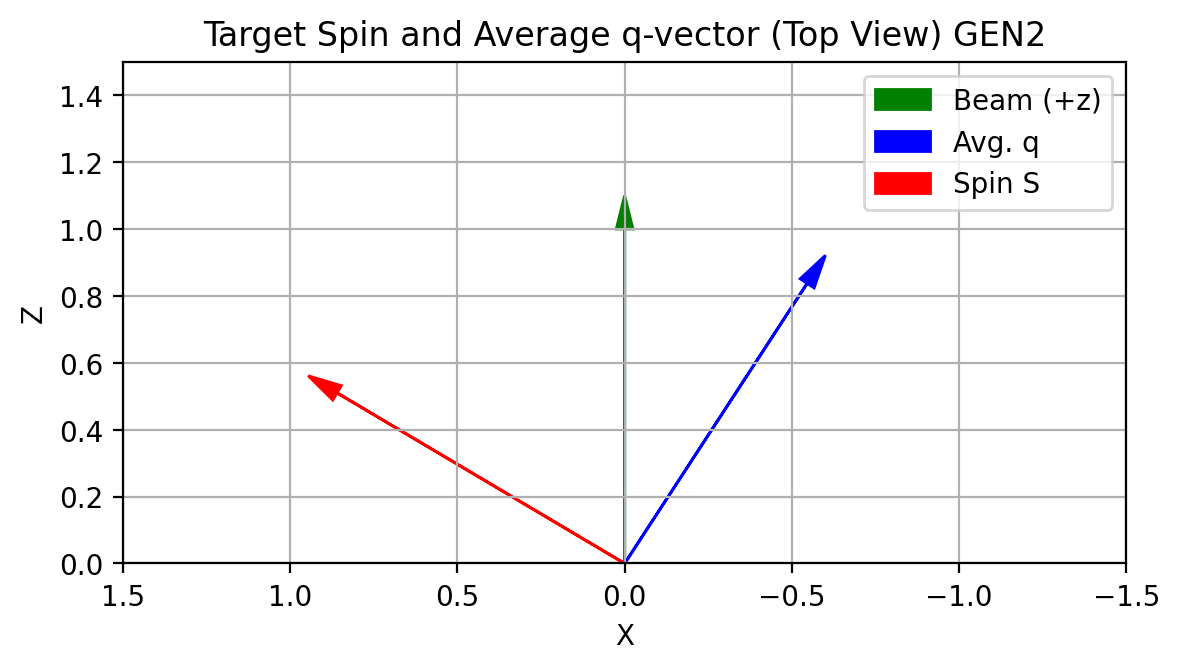

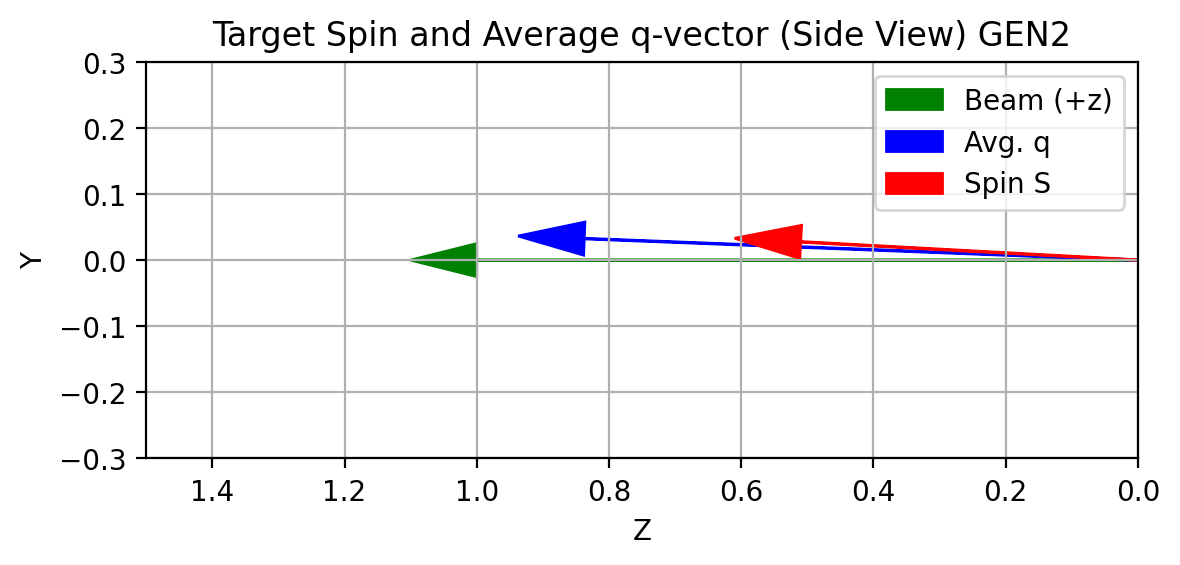

In [24]:
def compute_Px_Pz_special(trPx, trPy, trPz, ebeam, theta_deg, phi_deg):
    import numpy as np

    def spherical_to_cartesian(theta_deg, phi_deg):
        theta = np.radians(theta_deg)
        phi = np.radians(phi_deg)
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        return np.array([x, y, z])

    # Convert spin direction to unit vector
    S = spherical_to_cartesian(theta_deg, phi_deg)
    S /= np.linalg.norm(S)

    # Beam vector (along z)
    k_in_z = ebeam
    k_in_x = np.zeros_like(trPx)
    k_in_y = np.zeros_like(trPy)

    # q = k_in - k_out
    q_x = k_in_x - trPx
    q_y = k_in_y - trPy
    q_z = k_in_z - trPz

    q_mag = np.sqrt(q_x**2 + q_y**2 + q_z**2)
    valid_q = q_mag > 0
    q_x[~valid_q] = 1
    q_y[~valid_q] = 0
    q_z[~valid_q] = 0
    q_hat_x = q_x / q_mag
    q_hat_y = q_y / q_mag
    q_hat_z = q_z / q_mag

    # Cartesian unit vectors of q
    q_unit = np.vstack((q_hat_x, q_hat_y, q_hat_z)).T  # shape (N, 3)

    # n = k_in × k_out
    n_x = k_in_y * trPz - k_in_z * trPy
    n_y = k_in_z * trPx - k_in_x * trPz
    n_z = k_in_x * trPy - k_in_y * trPx

    n_mag = np.sqrt(n_x**2 + n_y**2 + n_z**2)
    valid_n = n_mag > 0
    n_x[~valid_n] = 1
    n_y[~valid_n] = 0
    n_z[~valid_n] = 0
    n_hat_x = n_x / n_mag
    n_hat_y = n_y / n_mag
    n_hat_z = n_z / n_mag

    # q̂ × S
    qxS_x = q_hat_y * S[2] - q_hat_z * S[1]
    qxS_y = q_hat_z * S[0] - q_hat_x * S[2]
    qxS_z = q_hat_x * S[1] - q_hat_y * S[0]

    # Px = n̂ ⋅ (q̂ × S)
    Px = n_hat_x * qxS_x + n_hat_y * qxS_y + n_hat_z * qxS_z

    # Pz = q̂ ⋅ S
    Pz = q_hat_x * S[0] + q_hat_y * S[1] + q_hat_z * S[2]

    # θ_q = angle between q and beam (z-axis)
    cos_theta_q = q_z / q_mag
    cos_theta_q = np.clip(cos_theta_q, -1, 1)
    theta_q_deg = np.degrees(np.arccos(cos_theta_q))

    # θ_qS = angle between q and spin vector S
    
    cos_theta_qS = np.clip(Pz, -1, 1)
    theta_qS_deg = np.degrees(np.arccos(cos_theta_qS))

    # θ_S = angle between S and beam (z-axis)
    theta_S_deg = np.degrees(np.arccos(S[2]))

    # Mask invalid
    valid = valid_q & valid_n
    Px[~valid] = np.nan
    Pz[~valid] = np.nan
    theta_q_deg[~valid] = np.nan
    theta_qS_deg[~valid] = np.nan
    q_unit[~valid] = np.nan

    return Px, Pz, theta_q_deg, theta_qS_deg, theta_S_deg, q_unit, S





import numpy as np
import matplotlib.pyplot as plt
# Call your function
Px, Pz, theta_q_deg, theta_qS_deg, theta_S_deg, q_unit, S = compute_Px_Pz_special(
    generic["trPx"][fullcut], generic["trPy"][fullcut], generic["trPz"][fullcut], generic["ebeam"][fullcut], spintheta, spinphi
)

# Filter valid q_unit vectors
valid = ~np.isnan(q_unit).any(axis=1)
avg_q = np.nanmean(q_unit[valid], axis=0)
avg_q /= np.linalg.norm(avg_q)

# Normalize spin vector
S = S / np.linalg.norm(S)

# Beam vector (+z)
beam = np.array([0, 0, 1])

# Project vectors onto x-z plane (ignore y)
def project_xz(v):
    return v[0], v[2]  # x, z

beam_xz = project_xz(beam)
avgq_xz = project_xz(avg_q)
spin_xz = project_xz(S)

# Plot in 2D
fig, ax = plt.subplots(figsize=(6, 6),dpi=200)

def draw_2d_arrow(v, color, label):
    ax.arrow(0, 0, v[0], v[1], head_width=0.05, head_length=0.1, fc=color, ec=color, label=label)
plt.grid(True)

draw_2d_arrow(beam_xz, 'green', 'Beam (+z)')
draw_2d_arrow(avgq_xz, 'blue', 'Avg. q')
draw_2d_arrow(spin_xz, 'red', 'Spin S')

# Set axis limits and appearance
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0, 1.5)
ax.set_aspect('equal')
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_title("Target Spin and Average q-vector (Top View) GEN2")
ax.legend()
ax.invert_xaxis()  # Make +x on the left, –x on the right
plt.tight_layout()
plt.show()
# Project vectors onto y-z plane (ignore x)
# Project vectors onto z-y plane (ignore x, return z, y)
def project_zy(v):
    return v[2], v[1]  # z → x-axis, y → y-axis

beam_zy = project_zy(beam)
avgq_zy = project_zy(avg_q)
spin_zy = project_zy(S)

# Plot in 2D (Z-Y side view: Z is horizontal, Y is vertical)
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)

def draw_2d_arrow_zy(v, color, label):
    ax.arrow(0, 0, v[0], v[1], head_width=0.05, head_length=0.1, fc=color, ec=color, label=label)

draw_2d_arrow_zy(beam_zy, 'green', 'Beam (+z)')
draw_2d_arrow_zy(avgq_zy, 'blue', 'Avg. q')
draw_2d_arrow_zy(spin_zy, 'red', 'Spin S')

# Set axis limits and appearance
ax.set_xlim(0, 1.5)
ax.set_ylim(-.3, .3)
ax.set_aspect('equal')
ax.set_xlabel("Z")
ax.set_ylabel("Y")
ax.set_title("Target Spin and Average q-vector (Side View) GEN2")
ax.legend()
ax.invert_xaxis()  # Make +z on the left, -z on the right
plt.grid(True)
plt.tight_layout()
plt.show()


# Peak at Cut Variables

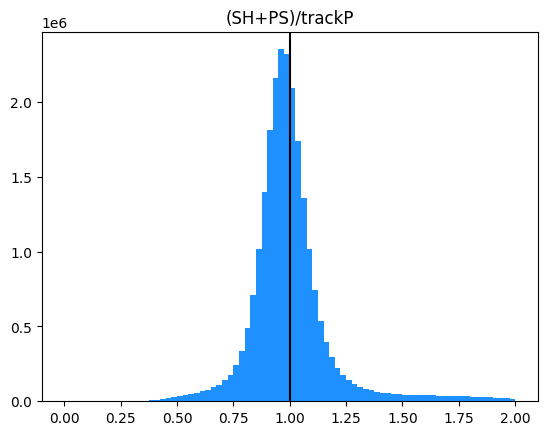

In [21]:
d=plt.hist(bbcalE/gemP,bins=80,range=(0,2),color='dodgerblue')
plt.axvline(1,color='black')
plt.title("(SH+PS)/trackP")
epcut=abs(bbcalE/gemP-.95)<.25

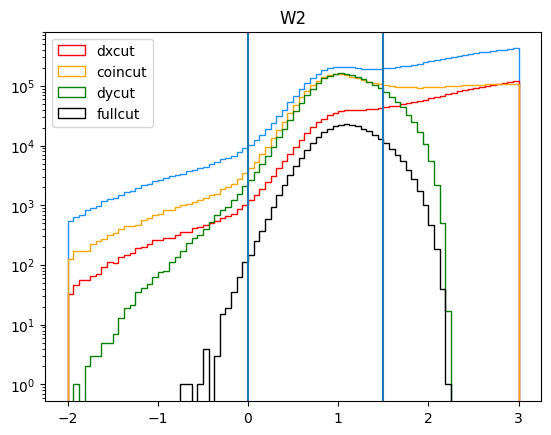

In [22]:
d=plt.hist(generic["W2"],bins=80,range=(-2,3),color='dodgerblue',histtype='step')
d=plt.hist(generic["W2"][dxcut],bins=80,range=(-2,3),color='red',label='dxcut',histtype='step')
d=plt.hist(generic["W2"][coincut],bins=80,range=(-2,3),color='orange',label='coincut',histtype='step')
d=plt.hist(generic["W2"][dycut],bins=80,range=(-2,3),color='green',label='dycut',histtype='step')
d=plt.hist(generic["W2"][dxcut&coincut&dycut],bins=80,range=(-2,3),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("W2")
plt.yscale("log")
plt.axvline(W2min)
plt.axvline(W2max)

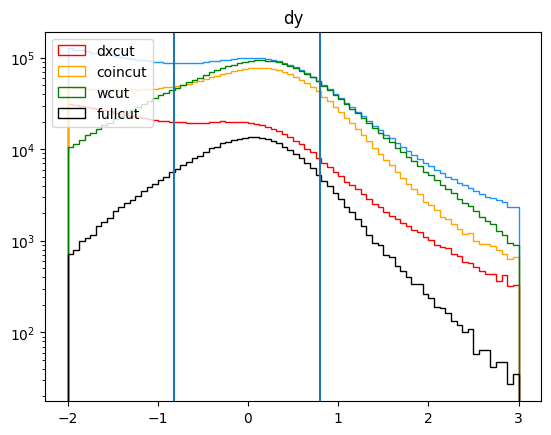

In [23]:
d=plt.hist(generic["dy"],bins=80,range=(-2,3),color='dodgerblue',histtype='step')
d=plt.hist(generic["dy"][dxcut],bins=80,range=(-2,3),color='red',label='dxcut',histtype='step')
d=plt.hist(generic["dy"][coincut],bins=80,range=(-2,3),color='orange',label='coincut',histtype='step')
d=plt.hist(generic["dy"][wcut],bins=80,range=(-2,3),color='green',label='wcut',histtype='step')
d=plt.hist(generic["dy"][dxcut&coincut&wcut],bins=80,range=(-2,3),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("dy")
plt.yscale("log")
plt.axvline(dymin)
plt.axvline(dymax)

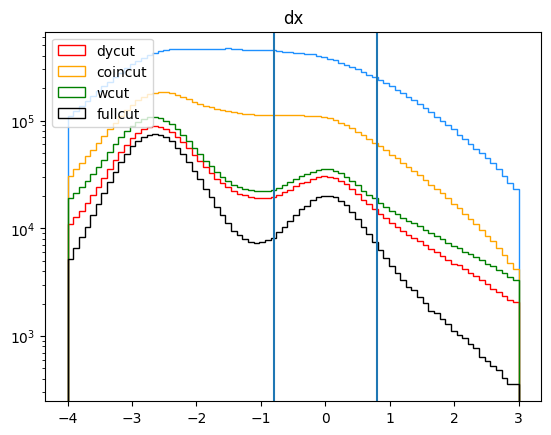

In [24]:
d=plt.hist(generic["dx"],bins=80,range=(-4,3),color='dodgerblue',histtype='step')
d=plt.hist(generic["dx"][dycut],bins=80,range=(-4,3),color='red',label='dycut',histtype='step')
d=plt.hist(generic["dx"][coincut],bins=80,range=(-4,3),color='orange',label='coincut',histtype='step')
d=plt.hist(generic["dx"][wcut],bins=80,range=(-4,3),color='green',label='wcut',histtype='step')
d=plt.hist(generic["dx"][dycut&coincut&wcut],bins=80,range=(-4,3),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("dx")
plt.yscale("log")
plt.axvline(dxmin)
plt.axvline(dxmax)

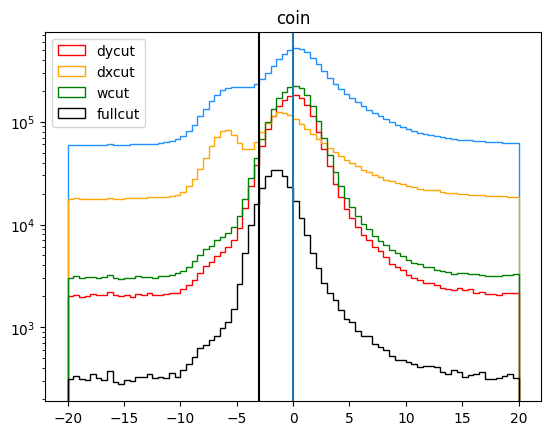

In [25]:
d=plt.hist(generic["coin_time"]-130,bins=80,range=(-20,20),color='dodgerblue',histtype='step')
d=plt.hist(generic["coin_time"][dycut]-130,bins=80,range=(-20,20),color='red',label='dycut',histtype='step')
d=plt.hist(generic["coin_time"][dxcut]-130,bins=80,range=(-20,20),color='orange',label='dxcut',histtype='step')
d=plt.hist(generic["coin_time"][wcut]-130,bins=80,range=(-20,20),color='green',label='wcut',histtype='step')
d=plt.hist(generic["coin_time"][dycut&wcut&dxcut]-130,bins=80,range=(-20,20),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("coin")
plt.yscale("log")

new_coinmin=coinmin+6.5-5/2
new_coinmax=coinmax-6.5+5/2

plt.axvline(new_coinmin-130,color='black')
plt.axvline(new_coinmax-130)



In [26]:
new_coinmin

127.0

# Entire Analysis

In [21]:

def weighted_avg(values, errors):
    values = np.asarray(values)
    errors = np.asarray(errors)
    
    mask = (errors > 0) & np.isfinite(errors)
    if not np.any(mask):
        raise ValueError("No valid data points: all errors are zero, negative, or non-finite.")

    weights = 1 / errors[mask]**2
    avg = np.sum(values[mask] * weights) / np.sum(weights)
    err = np.sqrt(1 / np.sum(weights))
    
    return avg, err


In [22]:
def calculate_Aphys_with_error(epsilon_bar, tau_bar, Lambda, Px_bar, Pz_bar, dLambda):
    """
    Calculate A_phys and its uncertainty from Lambda.

    Parameters:
    epsilon_bar : float
    tau_bar : float
    Lambda : float
    Px_bar : float
    Pz_bar : float
    dLambda : float
        Uncertainty in Lambda

    Returns:
    A_phys : float
    dA_phys : float
        Uncertainty in A_phys
    """
    E = epsilon_bar
    T = tau_bar
    L = Lambda
    Px = Px_bar
    Pz = Pz_bar

    sqrt_term = np.sqrt((2 * E * (1 - E)) / T)
    denom = 1 + (E / T) * L**2
    num = L * sqrt_term * Px + np.sqrt(1 - E**2) * Pz

    A_phys = -num / denom

    # Derivatives for error propagation
    d_num_dL = sqrt_term * Px
    d_denom_dL = 2 * (E / T) * L

    dA_dLambda = -(d_num_dL * denom - num * d_denom_dL) / denom**2
    dA_phys = abs(dA_dLambda) * dLambda

    return A_phys, dA_phys

    mup=2.793
    Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
def load_data(file_path):
    """
    Load the data from the given file path into a pandas DataFrame.
    """
    columns = ["Q2", "GEp/GD", "dGEp/GD", "dGEp_Par/GD", "GMp/mu_p/GD", "dGMp/mu_p/GD", "dGMp_Par/mu_p/GD"]
    data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns)
    return data
def find_closest_row(data, input_Q2):
    """
    Find the row in the data with the Q2 value closest to the input_Q2.
    """
    closest_row = data.iloc[(data['Q2'] - input_Q2).abs().argmin()]
    return closest_row
def main(input_Q2):
    file_path = '../DB/proton_lookup.dat'
    data = load_data(file_path)
    closest_row = find_closest_row(data, input_Q2)
    return closest_row

def propagate_errorAP(Ap, dAp, Pp, dPp, P_beam, dP_beam, P_target, dP_target):
    f = (Ap * Pp * P_beam * P_target) 
    rel_error_squared = (
        (dAp / Ap)**2 +
        (dPp / Pp)**2 +
        (dP_beam / P_beam)**2 +
        (dP_target / P_target)**2
    )
    df = f * np.sqrt(rel_error_squared)
    return f, df

In [23]:

if config=="2":
    Lower=-3.5#-5
    Upper=2

else:
    Lower=-4
    Upper=2.5

def Function_Fitdx(wcut,dycut,dxcut,coincut,fullcutfordx,protoncut,
                  neutroncut,pscut,epcut,hcalecut,Simwcut,Simdycut,bgcut,weight,extracut="1"):
    
    if (extracut=="4")|(extracut=="3")|(extracut=="1") :
        antibgcut=(generic["dy"]<-2)&wcut&coincut&pscut&epcut&hcalecut
    else:
        antibgcut=(abs(generic["dy"])>2)&wcut&coincut&pscut&epcut&hcalecut
        
    counts_p, bin_edges = np.histogram(genericSim["dx"][protoncut&Simwcut&Simdycut],   ####.065
                                       bins=80, range=(Lower, Upper),
                                       weights=weight[protoncut&Simwcut&Simdycut])

    counts_n, _         = np.histogram(genericSim["dx"][neutroncut&Simwcut&Simdycut],
                                       bins=bin_edges,
                                       weights=weight[neutroncut&Simwcut&Simdycut])
    #bgcut:  [bgcut&(goodsigmacut)]
    counts_bg,_         = np.histogram(dx_in[bgcut&(goodsigmacut)],
                                       bins=bin_edges,weights=sigma[bgcut&(goodsigmacut)])
    #counts_bg,_         = np.histogram(dx_in[bgcut&(goodsigmacut)],
    #                                   bins=bin_edges,weights=sigmaold[bgcut&(goodsigmacut)])
    counts_bg,_         = np.histogram(generic["dx"][antibgcut],
                                       bins=bin_edges)

    counts_data, _      = np.histogram(generic["dx"][fullcutfordx], bins=bin_edges)


    counts_p = counts_p.astype(float)
    counts_n = counts_n.astype(float)
    counts_bg = counts_bg.astype(float)
    #counts_acc = counts_acc.astype(float)
    counts_data = counts_data.astype(float)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    shape=("from data")
    if config=="2":
        shape=("from data")
    fit_obj = DistributionFits(bg_shape_option=shape)
    fit_obj.hdx_data = [bin_centers, counts_data]
    fit_obj.hdx_sim_p = [bin_centers, counts_p]
    fit_obj.hdx_sim_n = [bin_centers, counts_n]
    fit_obj.hdx_bg_data = [bin_centers, counts_bg] 
    #fit_obj.hdx_acc_data = [bin_centers, counts_acc] 


    if shape=="from data+acc":
        bg_fit, total_fit, sim_p_scaled, sim_n_scaled,pop0,pop1,pop2,pop3,scale,acc_fit= fit_obj.He3_fit_dists(True)
    else:
        bg_fit, total_fit, sim_p_scaled, sim_n_scaled,pop0,pop1,pop2,scale= fit_obj.He3_fit_dists(True)

    return bg_fit,total_fit,sim_p_scaled,sim_n_scaled,bin_centers,counts_data
def Function_Plotdx(bg_fit,total_fit,sim_p_scaled,sim_n_scaled,bin_centers,counts_data,dxmin,dxmax,extracut="1"):
    # Style config
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    fig, ax = plt.subplots(figsize=(10, 8))
    lw = 1.4
    l = 3
    fs = 16
    fw = 'bold'
    a = 1  # transparency for bars
    bin_width = bin_centers[1] - bin_centers[0]

    # Optional override
    if config == "2":
        lw = 1
        l = 3
        typ = "4th Order Poly"
    else:
        typ = "Background Data"



    # --------- Total Fit ---------hatch='///',
    ax.bar(bin_centers, total_fit, width=bin_width, align='center', alpha=0.7, color='orange', label="MC Fit = MC + Background")
    ax.plot(bin_centers, total_fit, '--', color='black', linewidth=lw)

    # --------- Inelastic ---------
    ax.bar(bin_centers, bg_fit, width=bin_width, align='center', alpha=0.7, color='magenta', label="MC Inelastic")
    ax.plot(bin_centers, bg_fit, '--', color='black', linewidth=lw)

    # --------- Accidental ---------
    #ax.bar(bin_centers, acc_fit, width=bin_width, align='center', alpha=0.5, color='magenta', label="MC Inelastic")
    #ax.plot(bin_centers, acc_fit, '--', color='black', linewidth=lw)

    # --------- Sim Proton ---------
    ax.bar(bin_centers, sim_p_scaled, width=bin_width, align='center', alpha=0.7, color='red', label="MC Proton")
    ax.plot(bin_centers, sim_p_scaled, '--', color='black', linewidth=lw)

    # --------- Sim Neutron ---------
    ax.bar(bin_centers, sim_n_scaled, width=bin_width, align='center', alpha=0.7, color='dodgerblue', label="MC Neutron")
    ax.plot(bin_centers, sim_n_scaled, '--', color='black', linewidth=lw)

    # --------- Data Line ---------
    ax.bar(bin_centers, counts_data, width=bin_width, align='center', alpha=.01, color='white',label="Data")
    ax.plot(bin_centers, counts_data, '-', color='grey',alpha=.8, linewidth=l, label='Data')

    # --------- Custom Legend ---------
    if (extracut=="4")|(extracut=="3")|(extracut=="1"):
        bgstring='BG data dy<-2'
    else:
        bgstring='BG data abs(dy)>'
    legend_elements = [
        Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
        Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
        Patch(facecolor='magenta', edgecolor='black', linestyle='--', label=bgstring, alpha=a),
        Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
        Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=fs)
    # --------- Labels, ticks, etc. ---------
    ax.set_title(f'Data/Simulation Comparison for GEN{config}: Δx (m)', fontsize=fs, fontweight=fw)
    ax.set_xlabel(r'$\Delta x$ (m)', fontsize=fs, fontweight=fw)
    ax.set_ylabel('Entries', fontsize=fs, fontweight=fw)
    ax.tick_params(axis='both', labelsize=fs-4)
    plt.xticks(fontsize=fs-4, fontweight=fw)
    plt.yticks(fontsize=fs-4, fontweight=fw)
    plt.tight_layout()
    #plt.yscale("log")
    plt.axvline(dxmin,color='black')
    plt.axvline(dxmax,color='black')
    # --------- Save and show ---------
    #plt.savefig(f'../plots/DataSimPass{pas}GEN{config}.png')
    plt.show()

    # Optional: Check total counts
    print("Total entries in fit:", np.sum(total_fit))


In [24]:

"""def Function_Acc(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin):
    
    wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
    dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
    dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
    hcalcut=generic["eHCAL"]>hcalmin
    accidentalcut=wcut&dycut&dxcut&epcut&runnumcut&hcalcut
    anticoincut=(coinmin-8 > generic["coin_time"])|(generic["coin_time"] > coinmax+5)
    
    accBinRange=100
    coin_hist,coin_edges=np.histogram(generic["coin_time"][accidentalcut],
                                      bins=200,range=(coinmin-accBinRange,coinmax+accBinRange))
    coin_centers= (coin_edges[:-1] + coin_edges[1:]) / 2


    outside_coin_right=(coin_centers >= coinmin+20) & (coin_centers <= coinmax+20)
    outside_coin_left=(coin_centers >= coinmin-20) & (coin_centers <= coinmax-20)
    inside_coin=(coin_centers >= coinmin) & (coin_centers <= coinmax)

    outside_number=(np.sum(coin_hist[outside_coin_right])+np.sum(coin_hist[outside_coin_left]))/2
    inside_number=(np.sum(coin_hist[inside_coin]))

    f_acc=outside_number/inside_number
    f_acc_error=f_acc * math.sqrt(1 / outside_number + 1 / inside_number)

    plus_coin_hist,plus_coin_edges=np.histogram(generic["coin_time"][anticoincut&accidentalcut&hpluscut],bins=100,range=(coinmin-30,coinmax+60))
    minus_coin_hist,minus_coin_edges=np.histogram(generic["coin_time"][anticoincut&accidentalcut&hminuscut],bins=100,range=(coinmin-30,coinmax+60))

    coin_plus_total = np.sum(plus_coin_hist)
    coin_minus_total = np.sum(minus_coin_hist)

    A_acc=(coin_plus_total-coin_minus_total)/(coin_plus_total+coin_minus_total)
    A_acc_error=2*math.sqrt(coin_plus_total * coin_minus_total) / (coin_plus_total + coin_minus_total)**(3/2)

    return f_acc,f_acc_error,A_acc,A_acc_error"""
    
def Function_Acc(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,psmin,epcut,ShowPlots=True):
    wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
    dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
    dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
    hcalcut=generic["eHCAL"]>hcalmin
    pscut=generic["ePS"]>psmin
    accidentalcut=wcut&dycut&dxcut&epcut&runnumcut&hcalcut&pscut&epcut
    anticoincut=(coinmin-8 > generic["coin_time"])|(generic["coin_time"] > coinmax+8)
    
    accBinRange=40
    #plt.figure(figsize=(8,6),dpi=200)
    coin_hist,coin_edges=np.histogram(generic["coin_time"][accidentalcut],
                                      bins=100,range=(coinmin-accBinRange,coinmax+accBinRange))
    coin_centers= (coin_edges[:-1] + coin_edges[1:]) / 2
    if ShowPlots:
        plt.figure(dpi=200)
        d=plt.hist(generic["coin_time"][accidentalcut],
                   bins=100,range=(coinmin-accBinRange,coinmax+accBinRange),color='orange',alpha=.4)
        plt.plot(coin_centers, coin_hist,'--',color='black',linewidth=1)

        plt.title(f"Cointime HCal-BBCal (ADC) GEN{config}")

        plt.axvline(coinmin,color='black')
        plt.axvline(coinmax,color='black')
        plt.axvspan(coinmin, coinmax, color='red', alpha=0.2)

        plt.axvline(coinmin+20,color='black')
        plt.axvline(coinmax+20,color='black')
        plt.axvspan(coinmin+20, coinmax+20, color='dodgerblue', alpha=0.3)

        plt.axvline(coinmin-20,color='black')
        plt.axvline(coinmax-20,color='black')
        plt.axvspan(coinmin-20, coinmax-20, color='dodgerblue', alpha=0.3)
        plt.xlabel("[ns]")

        #plt.yscale("log")
    outside_coin_right=(coin_centers >= coinmin+25) & (coin_centers <= coinmax+25)
    outside_coin_left=(coin_centers >= coinmin-25) & (coin_centers <= coinmax-25)
    inside_coin=(coin_centers >= coinmin) & (coin_centers <= coinmax)

    outside_number=(np.sum(coin_hist[outside_coin_right])+np.sum(coin_hist[outside_coin_left]))/2
    inside_number=(np.sum(coin_hist[inside_coin]))

    f_acc=outside_number/inside_number
    f_acc_error=f_acc * math.sqrt(1 / outside_number + 1 / inside_number)

    plus_coin_hist,plus_coin_edges=np.histogram(generic["coin_time"][anticoincut&accidentalcut&hpluscut],bins=100,range=(coinmin-30,coinmax+60))
    minus_coin_hist,minus_coin_edges=np.histogram(generic["coin_time"][anticoincut&accidentalcut&hminuscut],bins=100,range=(coinmin-30,coinmax+60))
    if ShowPlots:
        deez_hist,deez_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hcalcut&anticoincut],bins=100,
                range=(coinmin-30,coinmax+60))
        deez_centers= (deez_edges[:-1] + deez_edges[1:]) / 2
        plt.figure(dpi=200)
        plt.yscale("log")
        plt.title(f"Cointime HCal-BBCal (ADC) GEN{config}")
        plt.hist(generic["coin_time"][wcut&dycut&dxcut&hcalcut&anticoincut],bins=100,
                range=(coinmin-30,coinmax+60),color="dodgerblue",alpha=.5,label="Asymmetry Region")
        plt.plot(deez_centers, deez_hist,'--',color='black',linewidth=1)
        plt.xlabel("[ns]")
        deez_hist,deez_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hcalcut&coincut],bins=100,
                range=(coinmin-30,coinmax+60))
        deez_centers= (deez_edges[:-1] + deez_edges[1:]) / 2
        plt.hist(generic["coin_time"][wcut&dycut&dxcut&hcalcut&coincut],bins=100,
                range=(coinmin-30,coinmax+60),color="orange",alpha=.5,label="Coincidence Region")
        plt.plot(deez_centers, deez_hist,'--',color='black',linewidth=1)
        plt.legend(loc='upper right')
        
        plt.figure(dpi=200)
        plt.axvline(coinmin,color='black')
        plt.axvline(coinmax,color='black')
        plt.title(f"Cointime HCal-BBCal (ADC) GEN{config}")
        plt.xlabel("[ns]")
        deez_hist,deez_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hcalcut],bins=100,
                range=(coinmin-15,coinmax+15))
        deez_centers= (deez_edges[:-1] + deez_edges[1:]) / 2
        plt.hist(generic["coin_time"][wcut&dycut&dxcut&hcalcut],bins=100,
                range=(coinmin-15,coinmax+15),color="orange",alpha=.5)
        plt.plot(deez_centers, deez_hist,'--',color='black',linewidth=1)
    coin_plus_total = np.sum(plus_coin_hist)
    coin_minus_total = np.sum(minus_coin_hist)

    A_acc=(coin_plus_total-coin_minus_total)/(coin_plus_total+coin_minus_total)
    A_acc_error=2*math.sqrt(coin_plus_total * coin_minus_total) / (coin_plus_total + coin_minus_total)**(3/2)
    #print(f"N_plus: {coin_plus_total} N_minus: {coin_minus_total}")
    #print(f"f_acc: {f_acc:.4f}+={f_acc_error:.4f} A_acc: {A_acc:.6f}+-{A_acc_error:.4f}")
    return f_acc,f_acc_error,A_acc,A_acc_error

In [25]:
def Function_Proton(f_p,f_p_error):
    mup=2.793
    Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
    def load_data(file_path):
        """
        Load the data from the given file path into a pandas DataFrame.
        """
        columns = ["Q2", "GEp/GD", "dGEp/GD", "dGEp_Par/GD", "GMp/mu_p/GD", "dGMp/mu_p/GD", "dGMp_Par/mu_p/GD"]
        data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns)
        return data
    def find_closest_row(data, input_Q2):
        """
        Find the row in the data with the Q2 value closest to the input_Q2.
        """
        closest_row = data.iloc[(data['Q2'] - input_Q2).abs().argmin()]
        return closest_row
    def main(input_Q2):
        file_path = '../DB/proton_lookup.dat'
        data = load_data(file_path)
        closest_row = find_closest_row(data, input_Q2)
        return closest_row
    row=main(Q2)
    R=np.round(row[1]/row[4]/mup,4)


    #in GeV^2

    def Aperp(R, tau, theta):
        tan_half_theta = np.tan(np.radians(theta) / 2)
        numerator = -R * 2 * np.sqrt(tau * (tau + 1)) * tan_half_theta
        denominator = R**2 + (tau + 2 * tau * (1 + tau) * tan_half_theta**2)
        A_perp = numerator / denominator
        return A_perp

    Ap=Aperp(R,tau,theta)
    P_p=-.04 # seamus thesis
    P_beam=CONFIG.Function_JSON("Pbeam",f"../config/cuts{config}.cfg")
    P_target=CONFIG.Function_JSON("Ptarget",f"../config/cuts{config}.cfg")

    A_p=Ap*P_p*P_beam*P_target/100/100
    #Aphys_p=Ap*P_p*P_beam*P_target/100/100
    #print(f"f_p: {f_p:.4f}+={f_p_error:.4f} A_p: {A_p:.7f}")
    return A_p

In [26]:
def Function_Inelastic(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin):
    #hcalcut=generic["eHCAL"]>hcalmin

    antibgcut=(abs(generic["dy"])>1.2)&wcut&coincut
    antibgAcut=(abs(generic["dy"])>2)&wcut&coincut

    accBinRange=100
    #plt.figure(figsize=(8,6),dpi=200)
    inhist,coin_edges=np.histogram(generic["dx"][antibgcut],
                                      bins=200,range=(-4,3))
    coin_centers= (coin_edges[:-1] + coin_edges[1:]) / 2
    #d=plt.hist(generic["dx"][antibgcut],
    #                                  bins=200,range=(-4,3))


    plus_in_hist,plus_in_edges=np.histogram(generic["dx"][antibgAcut&hpluscut],bins=100,range=(dxmin,dxmax))
    minus_in_hist,minus_in_edges=np.histogram(generic["dx"][antibgAcut&hminuscut],bins=100,range=(dxmin,dxmax))

    in_plus_total = np.sum(plus_in_hist)
    in_minus_total = np.sum(minus_in_hist)
    #print(in_plus_total,in_minus_total)
    A_in=(in_plus_total-in_minus_total)/(in_plus_total+in_minus_total)
    A_in_error=2*math.sqrt(in_plus_total * in_minus_total) / (in_plus_total + in_minus_total)**(3/2)
    #print(f"N_plus: {coin_plus_total} N_minus: {coin_minus_total}")
    #print(f"f_acc: {f_acc:.4f}+={f_acc_error:.4f} A_acc: {A_acc:.6f}+-{A_acc_error:.4f}")
    return A_in,A_in_error

In [27]:
def Function_N2():
    hdx_sim_n=np.histogram(genericSim["dx"],range=(-.4,.4),
                       bins=100)
    he3simfrac=np.sum(hdx_sim_n[0])/len(genericSim["dx"])


    #the sim fraction
    n2simfrac=135874/268774

    n2overhe3counts=n2simfrac/he3simfrac/14 # divide by 14 because nitrogen molecule has 14 times n

    n2overhe3counts

    1.5*14*n2overhe3counts
    98.5

    nAtoms=100
    nN2=.015
    nHe3=.985

    f_n2=nN2*14/(14*nN2+nHe3)*n2overhe3counts
    
    f_n2=.0267 #CALCULATED IN NITROGEN CORRECTION NOTEBOOK
    f_n2_error=.02*f_n2
    
    
    return f_n2,f_n2_error

In [28]:
def ShowW2(dxcut,dycut,coincut,Simdycut,Simdxcut,InSimdycut,InSimdxcut,f_n,f_bg,f_p,W2min,W2max):
    neutronW2=neutroncut&Simdycut&Simdxcut
    protonW2=protoncut&Simdycut&Simdxcut
    bgW2=InSimdycut&InSimdxcut&goodsigmacut
    dataW2=dycut&dxcut&coincut
    # Data (no scaling/normalization for raw data)
    hist_data = plt.hist(generic["W2"][dataW2], bins=100, range=(W2min, W2max), color='black')
    counts_data, bins_data = hist_data[0], hist_data[1]
    scale=np.sum(counts_data)

    # Sim proton
    hist_p = plt.hist(genericSim["W2"][protonW2], bins=100,weights=weight[protonW2], range=(W2min, W2max), color='dodgerblue', alpha=0.5)
    counts_p, bins_p = hist_p[0], hist_p[1]
    norm_counts_p = counts_p / np.sum(counts_p)
    scaled_counts_p = norm_counts_p *(f_p)

    # Sim neutron
    hist_n = plt.hist(genericSim["W2"][neutronW2], bins=100, weights=weight[neutronW2],range=(W2min, W2max), color='red', alpha=0.5)
    counts_n, bins_n = hist_n[0], hist_n[1]
    norm_counts_n = counts_n / np.sum(counts_n)
    scaled_counts_n = norm_counts_n * (f_n)

    # Background
    hist_bg = plt.hist(genericSimIN["W2"][goodsigmacut], bins=100,weights=sigma[goodsigmacut], range=(W2min, W2max), color='orange', alpha=0.5)
    counts_bg, bins_bg = hist_bg[0], hist_bg[1]
    norm_counts_bg = counts_bg / np.sum(counts_bg)
    scaled_counts_bg = norm_counts_bg * (f_bg)


    # Bin centers
    bin_centers_p = 0.5 * (bins_p[1:] + bins_p[:-1])
    bin_centers_n = 0.5 * (bins_n[1:] + bins_n[:-1])
    bin_centers_bg = 0.5 * (bins_bg[1:] + bins_bg[:-1])
    bin_centers_data = 0.5 * (bins_data[1:] + bins_data[:-1])

    # Plot
    plt.figure(dpi=200)
    plt.step(bin_centers_p, scaled_counts_p*scale, where='mid', color='red', label='Proton Sim')
    plt.step(bin_centers_n, scaled_counts_n*scale, where='mid', color='dodgerblue', label='Neutron Sim')
    plt.step(bin_centers_bg, scaled_counts_bg*scale, where='mid', color='orange', label='BG Distribution')
    plt.step(bin_centers_data, counts_data, where='mid', color='black', label='Data')
    plt.step(bin_centers_data, scaled_counts_p*scale+scaled_counts_n*scale+scaled_counts_bg*scale, where='mid', color='grey', label='Sum of Sim')
    
    plt.title(f"W$^2$ GEN{config}")
    plt.xlabel(r"W$^2$ [GeV$^2$]")
    plt.ylabel("Counts (scaled)")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, np.max(counts_data)*1.1)
    plt.show()
    return

In [29]:
def ShowW2_fixed_ratio(dxcut, dycut, coincut, hcalecut, pscut, epcut,
                       Simdycut, Simdxcut, InSimdycut, InSimdxcut, InSimhcalcut,
                       f_n, f_p, W2min, W2max, Plot=True):
    # Define cuts
    neutronW2 = neutroncut & Simdycut & Simdxcut
    protonW2  = protoncut  & Simdycut & Simdxcut
    bgW2      = InSimdycut & goodsigmacut&InSimdxcut  # & InSimhcalcut
    dataW2    = dycut & dxcut & coincut & hcalecut & pscut & epcut

    # Fixed fit range
    fit_range = (-1, 2)
    bins = np.linspace(fit_range[0], fit_range[1], 60)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Histograms for full fixed range
    counts_data, _ = np.histogram(generic["W2"][dataW2], bins=bins)
    counts_p, _    = np.histogram(genericSim["W2"][protonW2],  bins=bins, weights=weight[protonW2])
    counts_n, _    = np.histogram(genericSim["W2"][neutronW2], bins=bins, weights=weight[neutronW2])
    counts_bg, _   = np.histogram(genericSimIN["W2"][bgW2],     bins=bins, weights=sigma[bgW2])

    # Normalize shapes
    counts_p_norm  = counts_p / np.sum(counts_p) if np.sum(counts_p) > 0 else counts_p
    counts_n_norm  = counts_n / np.sum(counts_n) if np.sum(counts_n) > 0 else counts_n
    counts_bg_norm = counts_bg / np.sum(counts_bg) if np.sum(counts_bg) > 0 else counts_bg

    # Combined proton + neutron model
    ratio_total = f_p + f_n
    shape_pn = (f_p * counts_p_norm + f_n * counts_n_norm) / ratio_total

    # Fit in the full fixed range
    def fit_func(x, A, B):
        return A * shape_pn + B * counts_bg_norm

    popt, _ = curve_fit(fit_func, bin_centers, counts_data, p0=[1, 1])
    A_fit, B_fit = popt

    # Get fitted distributions
    fitted_p  = A_fit * f_p / ratio_total * counts_p_norm
    fitted_n  = A_fit * f_n / ratio_total * counts_n_norm
    fitted_bg = B_fit * counts_bg_norm
    fitted_total = fitted_p + fitted_n + fitted_bg

    # Restrict to user-defined subrange for fraction reporting
    subrange_mask = (bin_centers >= W2min) & (bin_centers <= W2max)
    signal_area = np.sum(fitted_p[subrange_mask] + fitted_n[subrange_mask])
    bg_area = np.sum(fitted_bg[subrange_mask])

    if Plot:
        plt.figure(dpi=200)
        plt.step(bin_centers, counts_data, where='mid', color='black', label='Data')
        plt.step(bin_centers, fitted_p, where='mid', color='red', label=f'Proton')
        plt.step(bin_centers, fitted_n, where='mid', color='dodgerblue', label=f'Neutron')
        plt.step(bin_centers, fitted_bg, where='mid', color='orange', label=f'SIM ')
        plt.step(bin_centers, fitted_total, where='mid', color='gray', label='Total Fit')
        plt.title(f"W$^2$ GEN{config}")
        plt.xlabel(r"W$^2$ [GeV$^2$]")
        plt.ylabel("Counts")
        plt.legend()
        plt.grid(True)
        plt.ylim(0, np.max(counts_data) * 1.1)
        plt.axvline(W2min, color='gray', linestyle='--')
        plt.axvline(W2max, color='gray', linestyle='--')
        plt.show()

    total = signal_area + bg_area
    return (bg_area / total if total > 0 else np.nan,
            signal_area / total if total > 0 else np.nan)


def ShowW2_Datafit(dxcut, dycut, coincut, hcalecut, pscut, epcut,
                       Simdycut, Simdxcut, InSimdycut, InSimdxcut, InSimhcalcut,
                       f_n, f_p, W2min, W2max, Plot=True,extracut="2"):
    # Define cuts
    neutronW2 = neutroncut & Simdycut & Simdxcut
    protonW2  = protoncut  & Simdycut & Simdxcut
    print("extra",extracut)
    if extracut=="2":
        print("ABS")
        antidycut=(generic["dy"]>1.2)|(generic["dy"]<-1.2)
    else:
        print("NEGATIVE")
        antidycut=(generic["dy"]<-1.2)
    bgW2      = antidycut &dxcut& coincut & hcalecut & pscut & epcut # & InSimhcalcut
    dataW2    = dycut  &dxcut& coincut & hcalecut & pscut & epcut

    # Fixed fit range
    fit_range = (-1, 2)
    bins = np.linspace(fit_range[0], fit_range[1], 60)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Histograms for full fixed range
    counts_data, _ = np.histogram(generic["W2"][dataW2], bins=bins)
    counts_p, _    = np.histogram(genericSim["W2"][protonW2],  bins=bins, weights=weight[protonW2])
    counts_n, _    = np.histogram(genericSim["W2"][neutronW2], bins=bins, weights=weight[neutronW2])
    counts_bg, _   = np.histogram(generic["W2"][bgW2], bins=bins)

    # Normalize shapes
    counts_p_norm  = counts_p / np.sum(counts_p) if np.sum(counts_p) > 0 else counts_p
    counts_n_norm  = counts_n / np.sum(counts_n) if np.sum(counts_n) > 0 else counts_n
    counts_bg_norm = counts_bg / np.sum(counts_bg) if np.sum(counts_bg) > 0 else counts_bg

    # Combined proton + neutron model
    ratio_total = f_p + f_n
    shape_pn = (f_p * counts_p_norm + f_n * counts_n_norm) / ratio_total

    # Fit in the full fixed range
    def fit_func(x, A, B):
        return A * shape_pn + B * counts_bg_norm

    popt, _ = curve_fit(fit_func, bin_centers, counts_data, p0=[1, 1])
    A_fit, B_fit = popt

    # Get fitted distributions
    fitted_p  = A_fit * f_p / ratio_total * counts_p_norm
    fitted_n  = A_fit * f_n / ratio_total * counts_n_norm
    fitted_bg = B_fit * counts_bg_norm
    fitted_total = fitted_p + fitted_n + fitted_bg

    # Restrict to user-defined subrange for fraction reporting
    subrange_mask = (bin_centers >= W2min) & (bin_centers <= W2max)
    signal_area = np.sum(fitted_p[subrange_mask] + fitted_n[subrange_mask])
    bg_area = np.sum(fitted_bg[subrange_mask])

    if Plot:
        plt.figure(dpi=200)
        plt.step(bin_centers, counts_data, where='mid', color='black', label='Data')
        plt.step(bin_centers, fitted_p, where='mid', color='red', label=f'Proton')
        plt.step(bin_centers, fitted_n, where='mid', color='dodgerblue', label=f'Neutron')
        if extracut=="2":
            plt.step(bin_centers, fitted_bg, where='mid', color='orange', label=f'BG data abs(dy)>' )
        else:
            plt.step(bin_centers, fitted_bg, where='mid', color='orange', label=f'BG data dy<' )

        plt.step(bin_centers, fitted_total, where='mid', color='gray', label='Total Fit')
        plt.title(f"W$^2$ GEN{config}")
        plt.xlabel(r"W$^2$ [GeV$^2$]")
        plt.ylabel("Counts")
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.ylim(0, np.max(counts_data) * 1.1)
        plt.axvline(W2min, color='gray', linestyle='--')
        plt.axvline(W2max, color='gray', linestyle='--')
        plt.show()

    total = signal_area + bg_area
    return (bg_area / total if total > 0 else np.nan,
            signal_area / total if total > 0 else np.nan)

In [30]:
def DoItAll(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,
            psmin,epmin,printStats=True,printPlot=True,extracut="1"):
    
    #print(W2min,W2max,dxmin,dxmax,
    #     dymin,dymax,coinmin,coinmax)
    #print(W2max)
    bbcalE=generic["eSH"]+generic["ePS"]
    gemP=generic["trP"]
    wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
    dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
    dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
    coincut=(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)
    hcalecut=(generic["eHCAL"])>hcalmin
    epcut=bbcalE/gemP>epmin
    pscut=generic["ePS"]>psmin
    runnumcut=generic["runnum"]>2165

    fullcut=wcut&dycut&dxcut&coincut&epcut&runnumcut&hcalecut&hcalecut&pscut&(~(helicity==0))
    fullcutfordx=wcut&dycut&coincut&epcut&runnumcut&hcalecut&hcalecut&pscut
    accidentalcut=wcut&dycut&dxcut&epcut&runnumcut&hcalecut&hcalecut&pscut
    weight=genericSim["weight"]
    bgcut=(W2_in<W2max)&(W2_in>W2min)
    Simwcut=(genericSim["W2"] < W2max)&(genericSim["W2"]>W2min) 
    Simdycut=(genericSim["dy"]<dymax)&(genericSim["dy"]>dymin)
    InSimdxcut=(genericSimIN["dx"] < dxmax)&(genericSimIN["dx"]>dxmin)
    InSimdycut=(genericSimIN["dy"] < dymax)&(genericSimIN["dy"]>dymin)
    
    FitResult=Function_Fitdx(wcut,dycut,dxcut,
                            coincut,fullcutfordx,protoncut,
                            neutroncut,pscut,epcut,hcalecut,Simwcut,Simdycut,bgcut,weight,extracut=extracut)
   
    if printPlot:
        colors = ['white', 'dodgerblue', 'mediumaquamarine', 'gold', 'yellow']
        import matplotlib.colors as mcolors
        from matplotlib.patches import Patch
        import matplotlib.patches as patches
        # Create a custom color map
        cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
        plt.figure(dpi=200,figsize=(5,5))

        d=plt.hist2d(generic["dy"],generic["dx"],bins=(100,100),range=((-3,3),(-4,3)),cmap=cmap)
        edge_rect = patches.Rectangle((new_dymin, new_dxmin), abs(new_dymax-new_dymin), abs(new_dxmax-new_dxmin), linewidth=3,
                                      facecolor='none', edgecolor='red')
        plt.gca().add_patch(edge_rect)
        plt.title(f"GEN{config}")
        plt.xlabel("dy")
        plt.ylabel("dx")
        plt.figure(dpi=200,figsize=(5,5))

        d=plt.hist2d(generic["W2"],generic["dx"],bins=(100,100),range=((-3,3),(-4,3)),cmap=cmap)
        edge_rect = patches.Rectangle((new_W2min, new_dxmin), abs(new_W2max-new_W2min), abs(new_dxmax-new_dxmin), linewidth=3,
                                      facecolor='none', edgecolor='red')
        plt.gca().add_patch(edge_rect)
        plt.title(f"GEN{config}")
        plt.xlabel("W2")
        plt.ylabel("dx")
        plt.figure(dpi=200,figsize=(5,5))

        d=plt.hist2d(generic["dy"][coincut&epcut&runnumcut&hcalecut&pscut&wcut],
                      generic["dx"][coincut&epcut&runnumcut&hcalecut&pscut&wcut],
                      bins=(100,100),range=((-3,3),(-4,3)),cmap=cmap)
        edge_rect = patches.Rectangle((new_dymin, new_dxmin), abs(new_dymax-new_dymin), abs(new_dxmax-new_dxmin), linewidth=3,
                                      facecolor='none', edgecolor='red')
        plt.gca().add_patch(edge_rect)
        plt.title(f"GEN{config}")
        plt.xlabel("dy")
        plt.ylabel("dx")
        plt.figure(dpi=200,figsize=(5,5))

        d=plt.hist2d(generic["W2"][coincut&epcut&runnumcut&hcalecut&pscut&dycut],
                     generic["dx"][coincut&epcut&runnumcut&hcalecut&pscut&dycut],
                     bins=(100,100),range=((-3,3),(-4,3)),cmap=cmap)
        edge_rect = patches.Rectangle((new_W2min, new_dxmin), abs(new_W2max-new_W2min), abs(new_dxmax-new_dxmin), linewidth=3,
                                      facecolor='none', edgecolor='red')
        plt.gca().add_patch(edge_rect)
        plt.title(f"GEN{config}")
        plt.xlabel("W2")
        plt.ylabel("dx")
    
    bg_fit=FitResult[0]
    total_fit=FitResult[1]
    sim_p_scaled=FitResult[2]
    sim_n_scaled=FitResult[3]
    bin_centers=FitResult[4]
    counts_data=FitResult[5]
    mask = (bin_centers >= dxmin) & (bin_centers <= dxmax)

    # Sum the corresponding bin contents
    N_p  = np.sum(sim_p_scaled[mask])
    N_n  = np.sum(sim_n_scaled[mask])
    N_bg = np.sum(bg_fit[mask])
    N_total = np.sum(total_fit[mask])
   # N_total = np.sum(counts_data[mask])

    


    f_p=N_p/N_total
    f_bg=N_bg/N_total
    f_n=N_n/N_total
    f_p_error=f_p * math.sqrt(1 / N_p + 1 / N_total)
    f_bg_error=f_bg* math.sqrt(1 / N_bg + 1 / N_total)
    f_n_error=f_n* math.sqrt(1 / N_n + 1 / N_total)
    
    
    
     #############EXPERIMENTAL
    f_bg_old=f_bg
    f_n_old=f_n
    f_p_old=f_p
    f_bg_w2,f_np_w2=ShowW2_fixed_ratio(dxcut, dycut, coincut, hcalecut, pscut, epcut,
                       Simdycut, Simdxcut, InSimdycut, InSimdxcut, "FALSE",
                       f_n, f_p, W2min, W2max, Plot=True)
    
    print(extracut)
    f_bg_w2_d,f_np_w2_d=ShowW2_Datafit(dxcut, dycut, coincut,hcalecut,pscut,epcut,
                                       Simdycut, Simdxcut, InSimdycut, InSimdxcut,
                       "FALSE",f_n, f_p, W2min, W2max,Plot=True,extracut=extracut)
    
    if extracut=="1":
        f_p=f_p/f_n*f_np_w2
        f_n=f_np_w2-f_p
        f_bg=f_bg_w2
        f_bg_error=.07

        print(f_np_w2,f_p,f_n,f_bg)
    if extracut=="2":
        f_p=f_p/f_n*f_np_w2_d
        f_n=f_np_w2_d-f_p
        f_bg_error=.07
        f_bg=f_bg_w2_d
        print(f_np_w2,f_p,f_n,f_bg)
    if extracut=="3":
        f_p=f_p/f_n*f_np_w2_d
        f_n=f_np_w2_d-f_p
        f_bg_error=.07
        f_bg=f_bg_w2_d
        print(f_np_w2,f_p,f_n,f_bg)
    
    
    
    
    f_acc,f_acc_error,A_acc,A_acc_error=Function_Acc(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,
                                                    psmin,epcut)
    A_p=Function_Proton(f_p,f_p_error)
    f_nitrogen,f_nitrogen_error=Function_N2()
    
    if printPlot:
        Function_Plotdx(FitResult[0],FitResult[1],FitResult[2],FitResult[3],FitResult[4],FitResult[5],dxmin,
                        dxmax,extracut=extracut)
        #ShowW2(dxcut,dycut,coincut,Simdycut,Simdxcut,InSimdycut,InSimdxcut,f_n,f_bg,f_p,W2min,W2max)
    
    #temp below
    A_inelastic=0 #-.0075 
    A_inelastic_error=.002
    #A_inelastic,A_inelastic_error=Function_Inelastic(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin)
    #print("A, Ae: ",A_inelastic,A_inelastic_error)
#ARAW  #SWAPPED
    N_minus_raw=len(np.where(helicity[fullcut]==1)[0])
    N_plus_raw=len(np.where(helicity[fullcut]==-1)[0])
    #SEAN JEFFAS KIN3: N_minus_raw=20336
    #SEAN JEFFAS KIN3: N_plus_raw=21224
    #SEAN JEFFAS fN=.29
    #SEAN JEFFAS NEUTRONS: 12052.4
    NEUTRONSSSSS=f_n*(N_minus_raw+N_plus_raw)
    A_raw=(N_plus_raw-N_minus_raw)/(N_plus_raw+N_minus_raw)
    A_raw_error=2*math.sqrt(N_plus_raw * N_minus_raw) / (N_plus_raw + N_minus_raw)**(3/2)
    
    
    
#FILTER HELICITY    
    runs_filtered = generic["runnum"][fullcut]
    helicity_filtered = helicity[fullcut]
    # Now apply the run number cut:
    valid_runs = runs_filtered > 2165
    runs_filtered = runs_filtered[valid_runs]
    helicity_filtered = helicity_filtered[valid_runs]
    
#ARAW PER RUN #SWAPPED
    pluscut = helicity_filtered == -1
    minuscut = helicity_filtered == 1
    unique_runnum, run_idx = np.unique(runs_filtered, return_inverse=True)
    N_plus_per_run = np.bincount(run_idx, weights=pluscut.astype(int))
    N_minus_per_run = np.bincount(run_idx, weights=minuscut.astype(int))
    
   #CHECK FOR SAFE N VALUES
    A_raw_per_run = np.full_like(N_plus_per_run, np.nan, dtype=float)
    A_raw_error_per_run = np.full_like(N_plus_per_run, np.nan, dtype=float)
    valid = (N_plus_per_run > 0) & (N_minus_per_run > 0)
    denominator = (N_plus_per_run + N_minus_per_run)[valid]
    A_raw_per_run[valid] = (N_plus_per_run[valid] - N_minus_per_run[valid]) / denominator
    A_raw_error_per_run[valid] = 2 * np.sqrt(N_plus_per_run[valid] * N_minus_per_run[valid]) / denominator**1.5

    
    A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
    A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5
    A_raw_error_per_run=A_raw_error_per_run[~np.isnan(A_raw_per_run)]
    unique_runnum=unique_runnum[~np.isnan(A_raw_per_run)]
    A_raw_per_run=A_raw_per_run[~np.isnan(A_raw_per_run)]
    matching_pol_runs_i = np.searchsorted(target_run_num, unique_runnum)    
    P_beam_per_run = beam_pol[matching_pol_runs_i]/100
    P_beamE_per_run = beam_polE[matching_pol_runs_i]/100
    P_target_per_run = target_pol[matching_pol_runs_i]/100
    P_targetE_per_run = target_polE[matching_pol_runs_i]/100
    weightedaverage,weightedaverageE=weighted_avg(A_raw_per_run,A_raw_error_per_run)
    #print(P_target_per_run)
    #print(P_targetE_per_run)
    
    
#APHYS 
    f_inelastic=f_bg-f_acc-f_nitrogen
    if f_inelastic<0:
        print("Negative Fraction!")
        f_inelastic=0
    f_inelastic_error=np.sqrt(f_acc_error**2+f_bg_error**2)
    fA=f_acc*A_acc + f_inelastic*A_inelastic + f_p*A_p
    f=f_acc+f_nitrogen+f_p+f_inelastic
    P_neutron = 0.96
    A_corrected_per_run = (A_raw_per_run - fA) / (1 - f)
    f_neutron=(1-f)
    A_phys_per_run = A_corrected_per_run / (P_beam_per_run * P_target_per_run * P_neutron)
    statistical_error_per_run=A_raw_error_per_run/(P_beam_per_run * P_target_per_run * P_neutron*f_neutron)
    A_Phys_wavg,A_Phys_wavgE=weighted_avg(A_phys_per_run,statistical_error_per_run)
    
    
#Target and Beam
    P_target_avg,_ =weighted_avg(P_target_per_run,statistical_error_per_run)
    P_beam_avg,_ =weighted_avg(P_beam_per_run,statistical_error_per_run)
    P_target_error_avg,_ =weighted_avg(P_targetE_per_run,statistical_error_per_run)
    P_beam_error_avg,_ =weighted_avg(P_beamE_per_run,statistical_error_per_run)
    
    #plt.hist(P_targetE_per_run/P_target_per_run*100,bins=30)
    
    
#PROTON+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    goodhel=(helicity[fullcut]==1) | (helicity[fullcut]==-1)

    Q2_avg=np.mean(generic["Q2"][fullcut][goodhel])
    etheta_avg=np.mean(generic["etheta"][fullcut][goodhel])

    tau_avg=Q2_avg/(4*m**2)

    epsilon_avg=1/(1+2*(1+tau_avg)*math.tan(etheta_avg/2)**2)

    
    trPx = generic["trPx"][fullcut][goodhel]
    trPy = generic["trPy"][fullcut][goodhel]
    trPz = generic["trPz"][fullcut][goodhel]
    ebeam = generic["ebeam"][fullcut][goodhel]

    Px,Pz=compute_Px_Pz(trPx,trPy,trPz,ebeam,spintheta,spinphi)
    Px_avg=np.mean(Px)
    Pz_avg=np.mean(Pz)
   





    row=main(Q2_avg)
    R=np.round(row[1]/row[4]/mup,4)
    RE=R/mup*np.sqrt((row[2]/row[1])**2+(row[5]/row[4])**2)
    Ap,A_p_e=calculate_Aphys_with_error(epsilon_avg, tau_avg, R, Px_avg, Pz_avg,RE)
    P_p=-.03 # seamus thesis


    #A_p=Ap*P_p*P_beam_avg*P_target_avg
    A_p,A_p_sig=propagate_errorAP(Ap, A_p_e, P_p, 0, P_beam_avg, P_beam_error_avg, P_target_avg, P_target_error_avg)
    
#PROTON+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Error prop

    f1=f_acc
    sig_f1=f_acc_error

    A1=A_acc
    sig_A1=A_acc_error

    f2=f_p
    sig_f2=f_p_error

    A2=A_p
    sig_A2=A_p_sig

    f3=f_inelastic
    sig_f3=f_inelastic_error
    A3=A_inelastic
    sig_A3=A_inelastic_error

    f4=f_nitrogen
    sig_f4=f_nitrogen_error

    Pb=P_beam_avg
    sig_Pb=P_beam_error_avg
    Pt=P_target_avg
    sig_Pt=P_target_error_avg
    #sig_Pt=0
    Pn=P_neutron
    sig_Pn=.02
    P_total=Pb*Pt*Pn
    sig_P_total = ((sig_Pb / Pb)**2 + (sig_Pt / Pt)**2+(sig_Pn/P_neutron)**2)**0.5
    fn=1-f1-f2-f3-f4
    #print(fn)
    A = A_Phys_wavg
    P=P_total
    
    dAdf1=((A*P-A1)/(P*fn)*sig_f1)**2
    dAdf2=((A*P-A2)/(P*fn)*sig_f2)**2
    dAdf3=((A*P-A3)/(P*fn)*sig_f3)**2
    dAdf4=((A*P)/(P*fn)*sig_f4)**2

    dAdA1=(f1/(P*fn)*sig_A1)**2
    dAdA2=(f2/(P*fn)*sig_A2)**2
    dAdA3=(f3/(P*fn)*sig_A3)**2

    #dAdP=(A/P**2*sig_P_total)**2
    dAdP=(A*sig_P_total)**2

    A_phys_sys_error=(dAdf1+dAdf2+dAdf3+dAdf4+dAdA1+dAdA2+dAdA3+dAdP)**(1/2)
    A_phys_stat_error=A_Phys_wavgE
    A_phys_comb_error=np.sqrt(A_phys_sys_error**2+A_phys_stat_error**2)

    
    total_var = dAdf1 + dAdf2 + dAdf3 + dAdf4 + dAdA1 + dAdA2 + dAdA3 + dAdP
    rel_contribs = {
        "f_acc": 100*dAdf1 / total_var,
        "f_p": 100*dAdf2 / total_var,
        "f_inelastic": 100*dAdf3 / total_var,
        "f_N2": 100*dAdf4 / total_var,
        "A_acc": 100*dAdA1 / total_var,
        "A_p": 100*dAdA2 / total_var,
        "A_inelastic": 100*dAdA3 / total_var,
        "P": 100*dAdP / total_var
    }

    """    print("A =", A)
    print("P =", P)
    print("σ_P =", sig_P_total)
    print("term =", (A / P**2) * sig_P_total)"""

    
    
    goodhel=(helicity[fullcut]==1) | (helicity[fullcut]==-1)
    Q2_avg=np.mean(generic["Q2"][fullcut][goodhel])
    etheta_avg=np.mean(generic["etheta"][fullcut][goodhel])
    tau_avg=Q2_avg/(4*m**2)
    epsilon_avg=1/(1+2*(1+tau_avg)*math.tan(etheta_avg/2)**2)
    
    
    trPx = generic["trPx"][fullcut][goodhel]
    trPy = generic["trPy"][fullcut][goodhel]
    trPz = generic["trPz"][fullcut][goodhel]
    ebeam = generic["ebeam"][fullcut][goodhel]
    Px,Pz=compute_Px_Pz(trPx,trPy,trPz,ebeam,spintheta,spinphi)
    Px_avg=np.mean(Px)
    Pz_avg=np.mean(Pz)
    
    
    
    A=epsilon_avg/tau_avg*A_Phys_wavg
    B=np.sqrt((2*epsilon_avg)*(1-epsilon_avg)/tau_avg)*Px_avg
    C=A_Phys_wavg+np.sqrt(1-epsilon_avg**2)*Pz_avg

    A_error_stat = (epsilon_avg / tau_avg) * A_phys_stat_error
    C_error_stat = A_phys_stat_error
    A_error_sys = (epsilon_avg / tau_avg) * A_phys_sys_error
    C_error_sys = A_phys_sys_error

    # Results
    
    ratio=(-B+np.sqrt(B**2-4*A*C))/(2*A)
    discriminant = B**2 - 4*A*C
    ratio_error_stat = np.sqrt(((C / (A * np.sqrt(discriminant)) + ratio / A)**2) * A_error_stat**2 + (C_error_stat**2 / discriminant))
    ratio_error_sys = np.sqrt(((C / (A * np.sqrt(discriminant)) + ratio / A)**2) * A_error_sys**2 + (C_error_sys**2 / discriminant))
    
    if printStats:
        print(f"Total events in range ({dxmin}, {dxmax}):")
        print(f"  Sim Proton:   {N_p:.2f}")
        print(f"  Sim Neutron:  {N_n:.2f}")
        print(f"  Background:   {N_bg:.2f}")
        print(f"  Total:        {N_total:.2f}")
        print(f"Fraction of events in range ({dxmin}, {dxmax}):")
        print(f"   Proton Fraction: {f_p:.2f}")
        print(f"   Background Fraction: {f_bg:.2f}")
        print(f"   Neutron Fraction: {f_n:.2f}") 
        print("__________________________________________________")
        print(f"Target Weighted Avg: {P_target_avg:.3}+-{P_target_error_avg:.4f}  {100*P_target_error_avg/P_target_avg:.4f}%")
        print(f"Beam Weighted Avg: {P_beam_avg:.3}+-{P_beam_error_avg:.4f}  {100*P_beam_error_avg/P_beam_avg:.4f}%")

        print("__________________________________________________")
        print(f"epsilon = {epsilon_avg:.4f}")
        print(f"tau_avg = {tau_avg:.4f}")
        print(f"Q2 = {Q2_avg:.4f}")
        print(f"Px: {Px_avg:.4f} Pz: {Pz_avg:.4f}")
        print(f"A = {A:.5f} ± {A_error_stat:.5f} ± {A_error_sys:.5f}")
        print(f"B = {B:.5f} (no propagated error)")
        print(f"C = {C:.5f} ± {C_error_stat:.5f} ± {C_error_sys:.5f}")

        print("__________________________________________________")

        print(f"N_plus: {N_plus_raw} N_minus: {N_minus_raw}")
        print(f"A_raw: {A_raw:.4f}+={A_raw_error:.4f}")
        print(f"A_raw_weighted: {weightedaverage:.3}+-{weightedaverageE:.4f}  {100*weightedaverageE/weightedaverage:.4f}%")

        print("__________________________________________________")
        print(f"A_phys_weighted: {A_Phys_wavg:.3}")
        print(f"A_phys_stat_error: {A_Phys_wavgE:.4f}  {A_Phys_wavgE/A_Phys_wavg*100:.4f}%")
        print(f"A_phys_sys_error: {A_phys_sys_error:.4f}  {A_phys_sys_error/A_Phys_wavg*100:.4}%")
        print(f"GEn/GMn*muN_stat_error: {ratio_error_stat*muN:.5f}  {abs(ratio_error_stat/ratio)*100:.4f}%")
        print(f"GEn/GMn*muN_phys_sys_error: {ratio_error_sys*muN:.5f}  {abs(ratio_error_sys/ratio)*100:.4}%")
        print(f"GEn/GMn*muN: {ratio*muN:.5f}+-{ratio_error_stat*muN:.5f}+-{ratio_error_sys*muN:.5f}")

    statdict = {
        "N_p": f_p*np.sum(fullcut),
        "N_n": f_n*np.sum(fullcut),
        "N_bg": f_bg*np.sum(fullcut),
        "N_total": np.sum(fullcut),
        "f_p": f_p,
        "f_p_e":f_p_error,
        "f_bg": f_bg,
        "f_bg_e": f_bg_error,
        "f_n": f_n,
        "f_n_e":f_n_error,
        "f_nitrogen":f_nitrogen,
        "f_nitrogen_e":f_nitrogen_error,
        "f_acc":f_acc,
        "f_acc_e":f_acc_error,
        "f_inelastic":f_inelastic,
        "f_inelastic_e":f_inelastic_error,
        "A_acc": A_acc,
        "A_acc_e":A_acc_error,
        "A_p":A_p,
        "A_p_e":A_p_sig,
        "A_inelastic":A_inelastic,
        "A_inelastic_e":A_inelastic_error,
        "P_beam":P_beam_avg,
        "P_beam_e":P_beam_error_avg,
        "P_target":P_target_avg,
        "P_target_e":P_target_error_avg,
        "P_neutron":Pn,
        "P_neutron_e":sig_Pn,
        "N_plus_raw": N_plus_raw,
        "N_minus_raw": N_minus_raw,
        "A_raw": A_raw,
        "A_raw_rel_error": A_raw_error / A_raw,
        "A_Phys_wavg": A_Phys_wavg,
        "A_phys_rel_sys_error": A_phys_sys_error / A_Phys_wavg,
        "A_phys_rel_sat_error": A_Phys_wavgE / A_Phys_wavg,
        "etheta":etheta_avg,
        "tau":tau_avg,
        "epsilon":epsilon_avg,
        "Q2":Q2_avg,
        "Px":Px_avg,
        "Pz":Pz_avg,
        "GE/GM * muN": ratio * muN,
        "GE/GM_stat_error": abs(ratio_error_stat * muN),
        "GE/GM_sys_error": abs(ratio_error_sys * muN)
    }

    
    return rel_contribs,total_var, statdict,Q2_avg
    

In [31]:
##Kin2

"""new_W2min=.87-9/10
new_W2max=.88+9/20
new_dxmin=-.1-10/20
new_dxmax=.1+10/20
new_dymin=-.1-5/10
new_dymax=.1+5/10

new_coinmin=coinmin+6.5-5/2
new_coinmax=coinmax-5.5+5/2"""

new_W2min=.87-8/10
new_W2max=1.5#.88+8/20
new_dxmin=-.1-17/20
new_dxmax=.1+17/20
new_dymin=-.1-6/10
new_dymax=.1+6/10
psmin=.2
epmin=.7
new_coinmin=coinmin+6.5-7/2
new_coinmax=coinmax-6.5+7/2


In [32]:
print(f"{new_W2min:.4f}")
print(f"{new_W2max:.4f}")
print(f"{new_dxmin:.4f}")
print(f"{new_dxmax:.4f}")
print(f"{new_dymin:.4f}")
print(f"{new_dymax:.4f}")
print(f"{new_coinmin:.4f}")
print(f"{new_coinmax:.4f}")


0.0700
1.5000
-0.9500
0.9500
-0.7000
0.7000
126.0000
131.0000


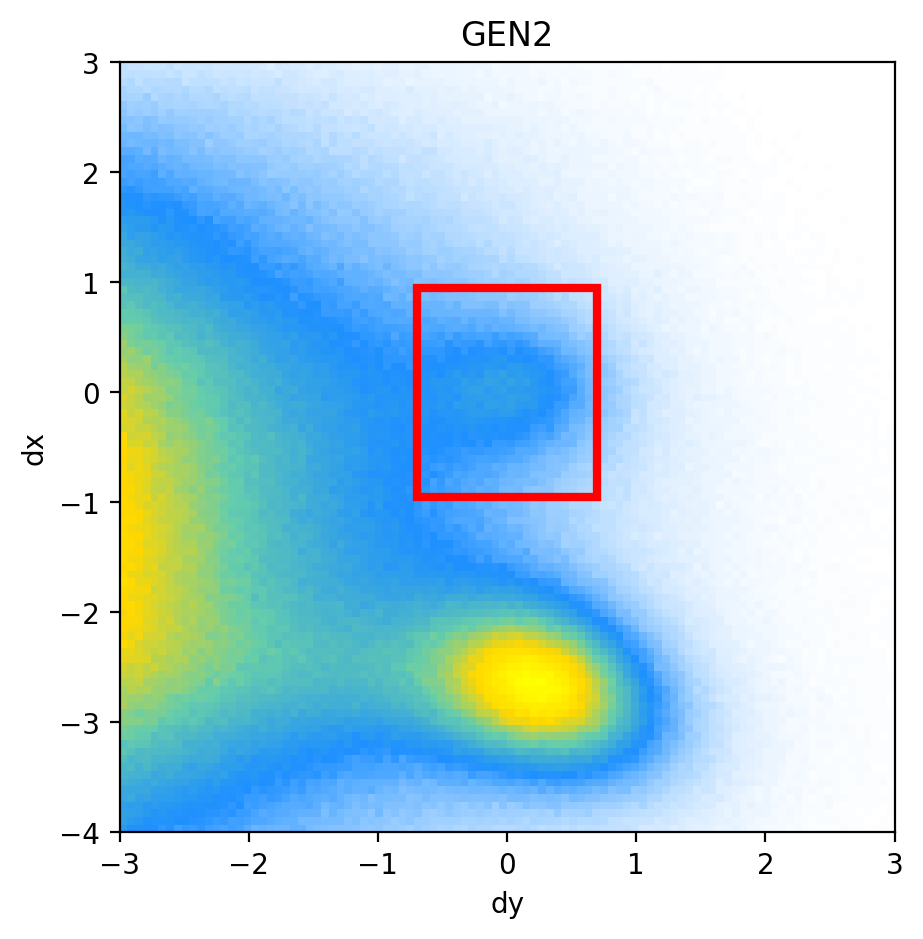

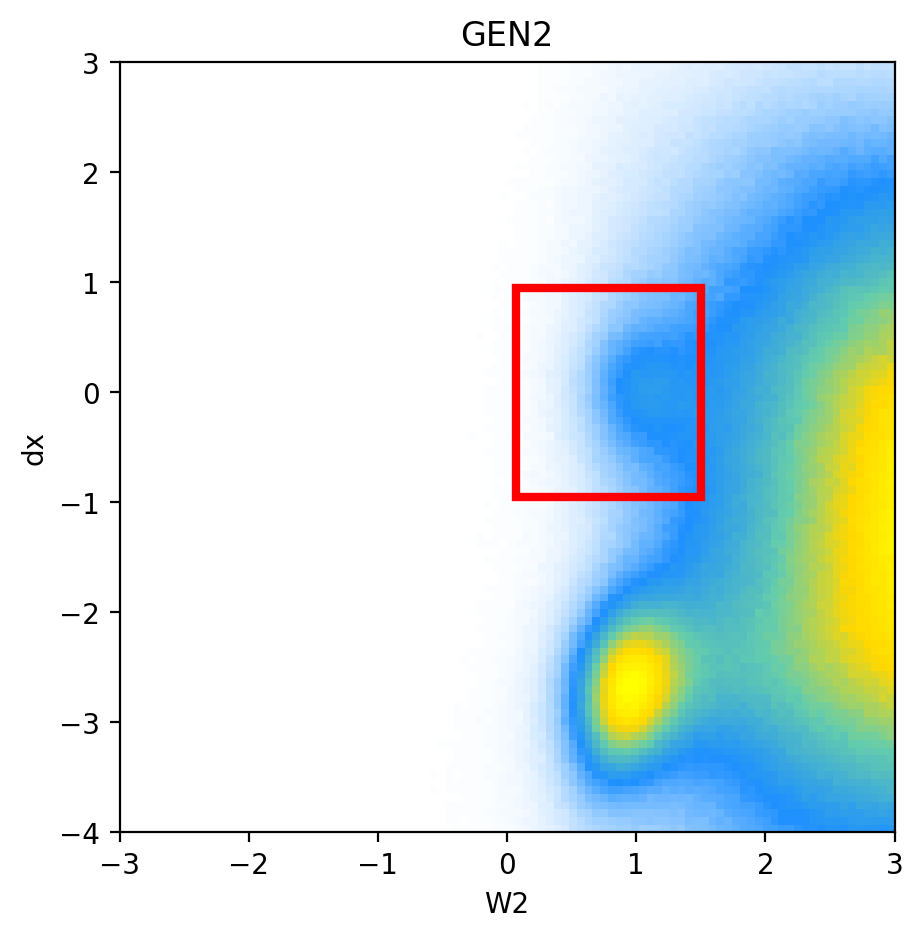

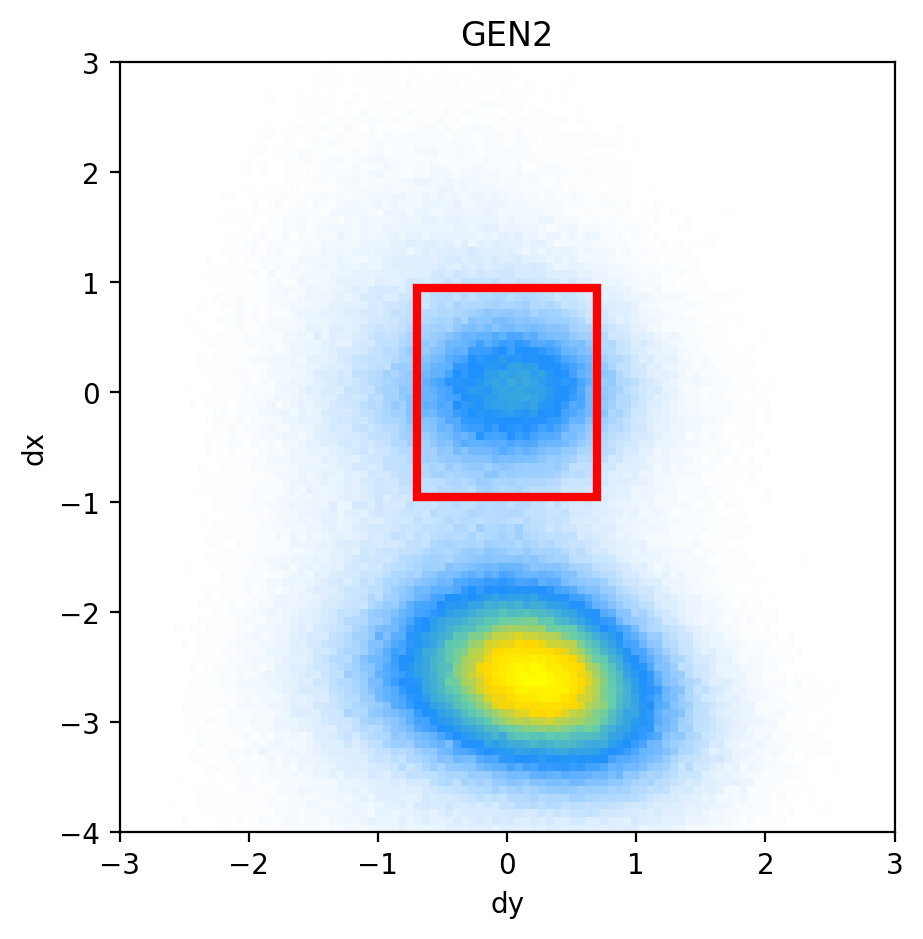

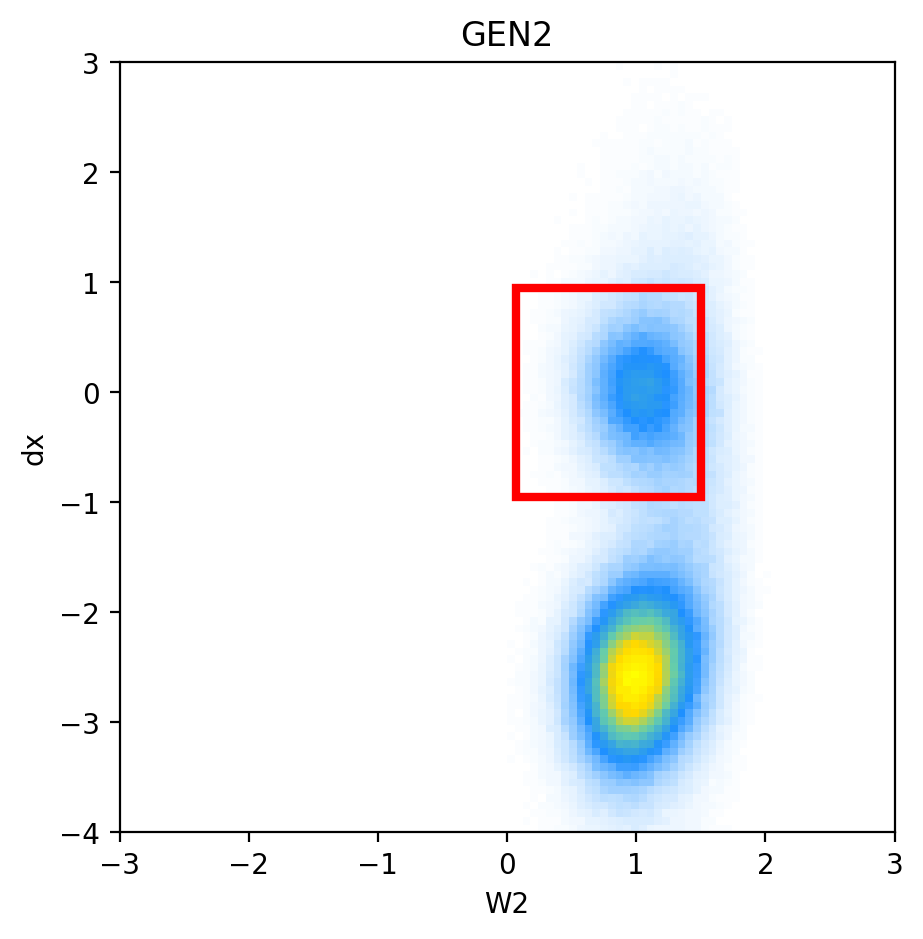

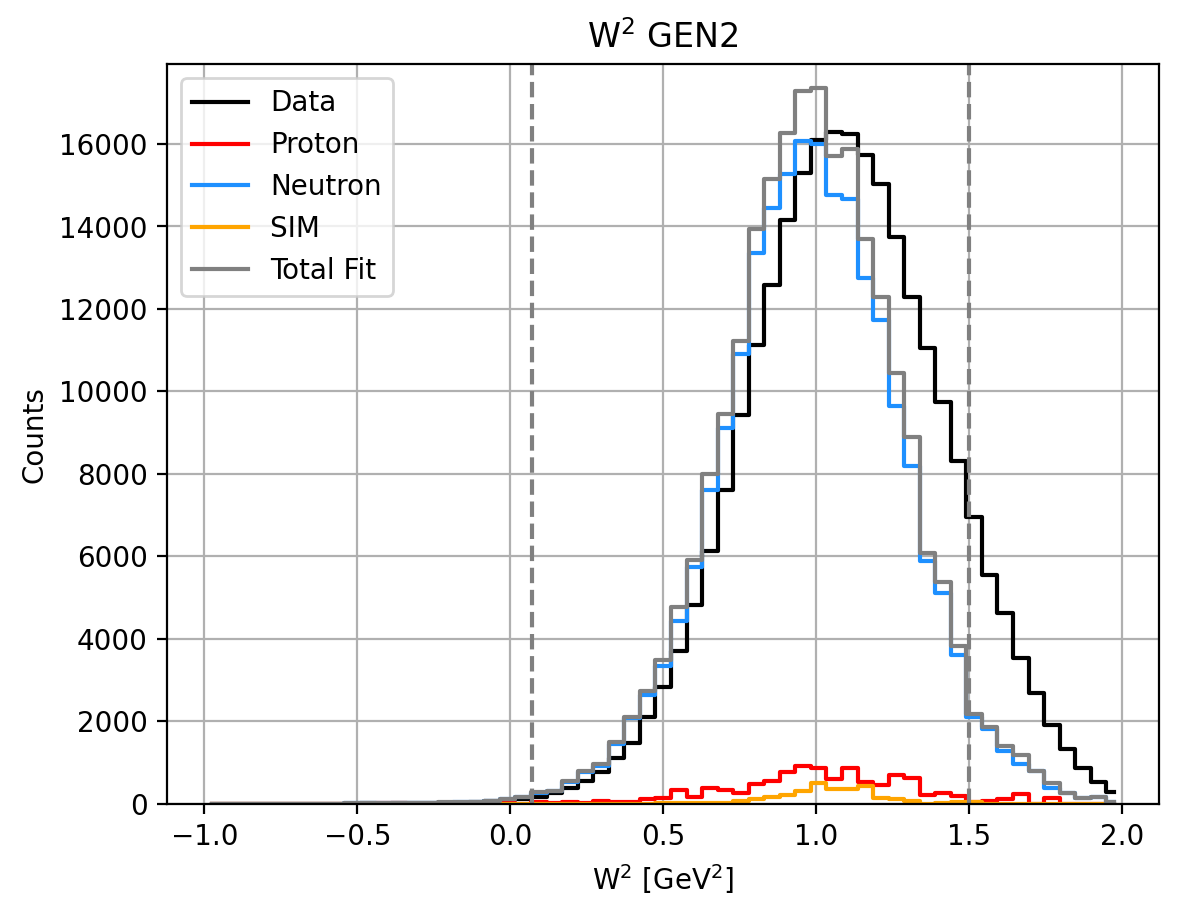

4
extra 4
NEGATIVE


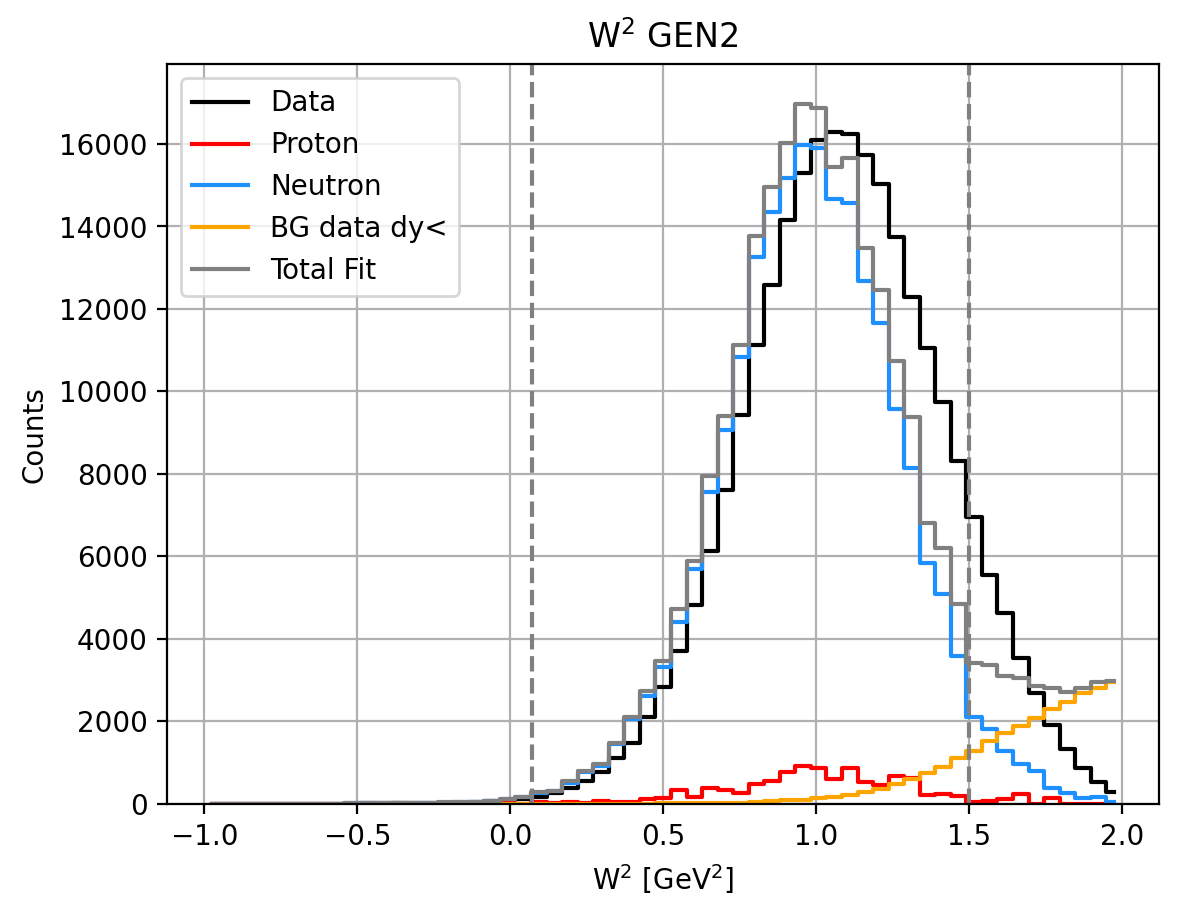

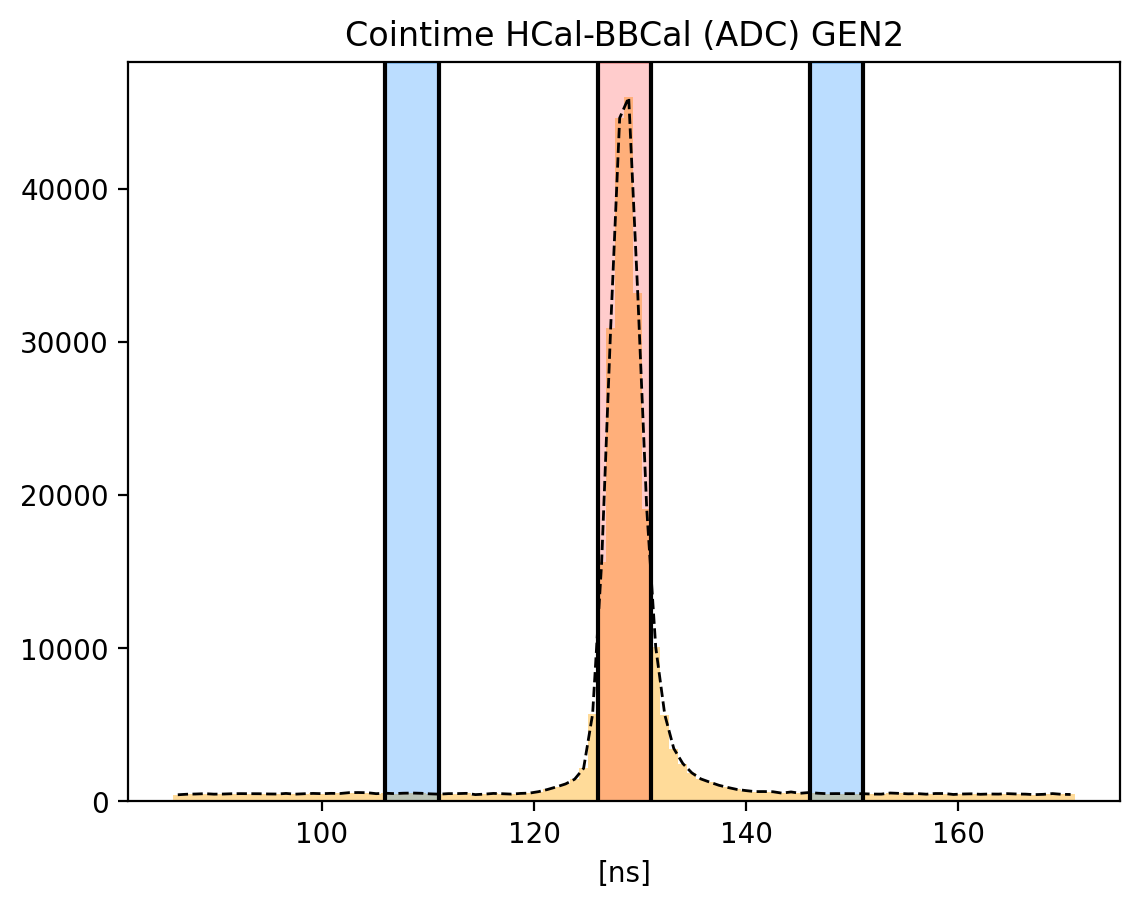

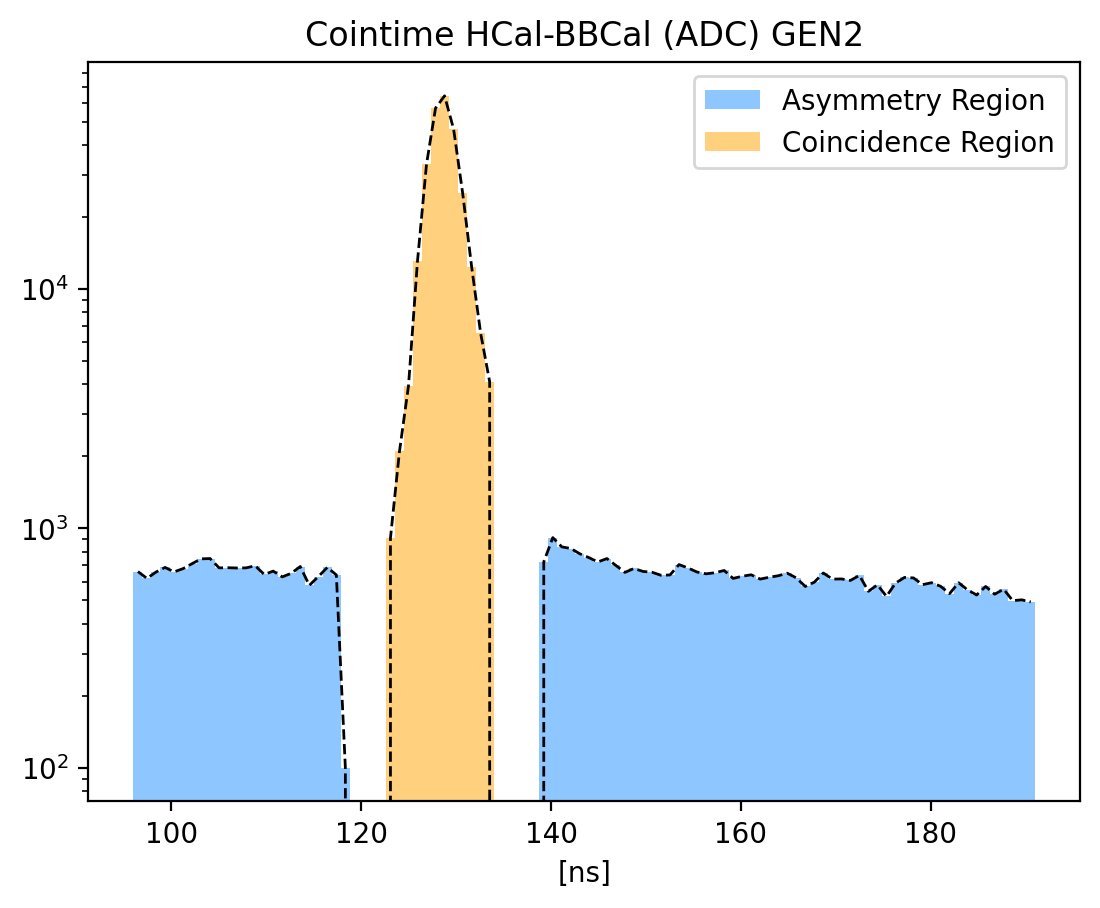

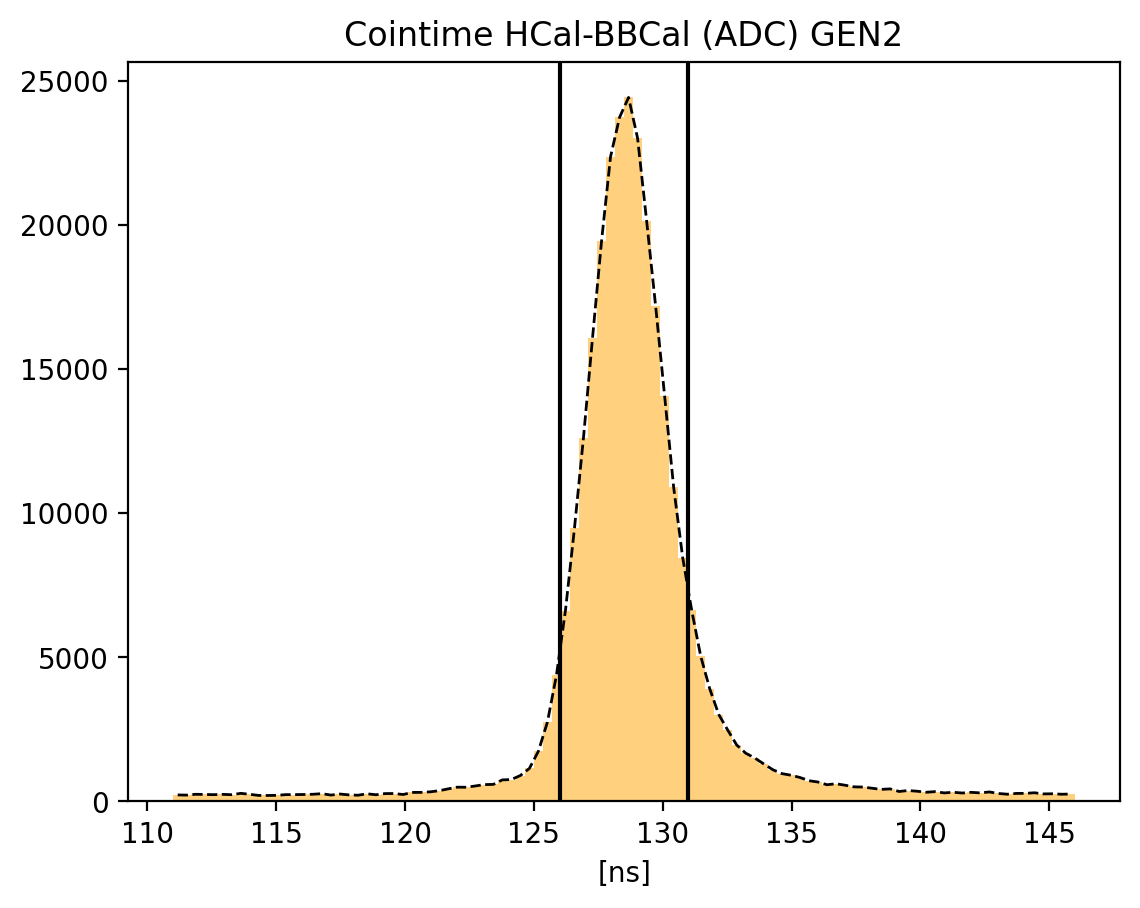

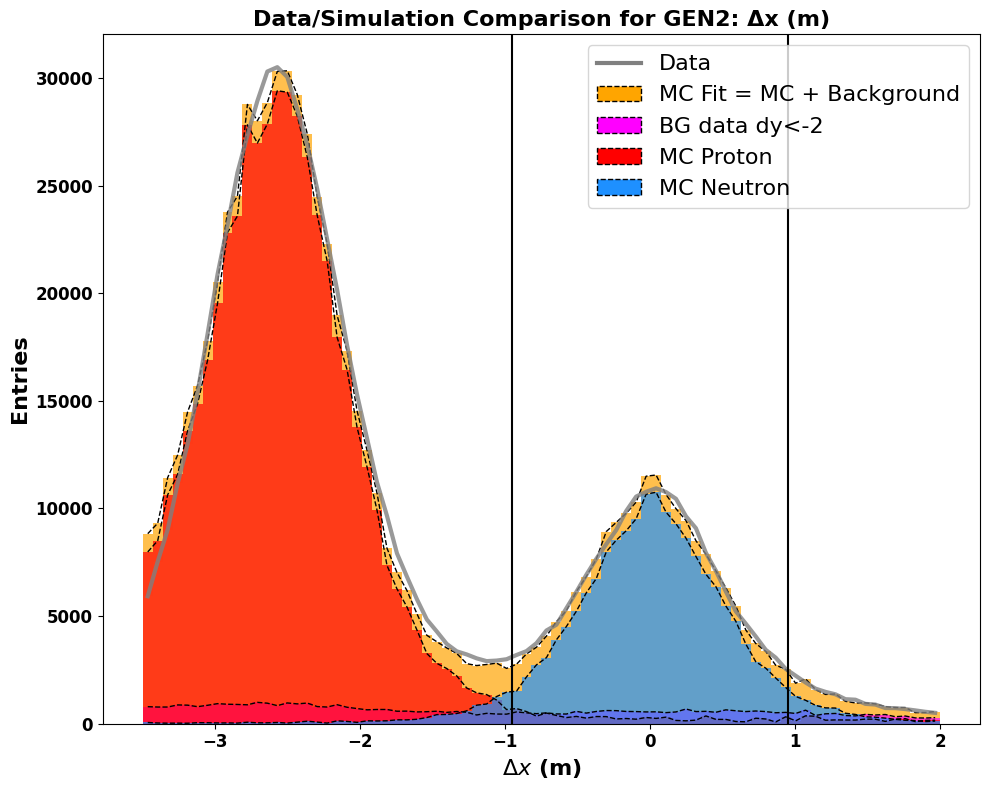

Total entries in fit: 741313.3834386084
Total events in range (-0.95, 0.95):
  Sim Proton:   7852.90
  Sim Neutron:  164372.50
  Background:   15438.24
  Total:        187663.64
Fraction of events in range (-0.95, 0.95):
   Proton Fraction: 0.04
   Background Fraction: 0.08
   Neutron Fraction: 0.88
__________________________________________________
Target Weighted Avg: 0.356+-0.0179  5.0366%
Beam Weighted Avg: 0.841+-0.0018  0.2152%
__________________________________________________
epsilon = 0.7988
tau_avg = 0.8301
Q2 = 2.9311
Px: 0.9909 Pz: -0.0412
A = 0.15488 ± 0.00903 ± 0.00846
B = 0.61663 (no propagated error)
C = 0.13619 ± 0.00938 ± 0.00879
__________________________________________________
N_plus: 96153 N_minus: 88720
A_raw: 0.0402+=0.0023
A_raw_weighted: 0.0402+-0.0023  5.7734%
__________________________________________________
A_phys_weighted: 0.161
A_phys_stat_error: 0.0094  5.8279%
A_phys_sys_error: 0.0088  5.463%
GEn/GMn*muN_stat_error: -0.03299  7.3582%
GEn/GMn*muN_phys_s

In [33]:
#rel_contribs,_,statdict,Q2_avg=DoItAll(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax)
rel_contribs,_,statdict,Q2_avg=DoItAll(new_W2min,new_W2max,new_coinmin,
                                       new_coinmax,new_dymin,new_dymax,new_dxmin,new_dxmax,hcalmin,
                                      psmin,epmin,extracut="4")




In [ ]:
gen=[]
gensys=[]
genstat=[]
araw=[]
arawerror=[]
aphysstaterror=[]
aphyssyserror=[]
cutindex=[]
#w2scale
#coinscale
#dyscale
#dxscale


stepsize=20
print("Starting W2")
for i in range(0,stepsize):
    #print(i)
    try: _,_,stats1,_=DoItAll(.87-i/10,.88+i/20,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,False,False)
    except:
        continue
    cutindex.append(i)
    A=stats1['GE/GM * muN']
    B=stats1['GE/GM_stat_error']
    #print(A,B)
    C=stats1['GE/GM_sys_error']
    D=stats1['A_raw']
    E=stats1['A_raw_rel_error']
    F=stats1["A_phys_rel_sys_error"]
    G=stats1["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("Starting dx")
for i in range(0,20):
    #print(i)
    try: _,_,stats2,_=DoItAll(.87-8/10,.88+8/20,coinmin,coinmax,dymin,dymax,-.1-i/20,.1+i/20,hcalmin,False,False)
    except:
        continue
    cutindex.append(stepsize+i)
    A=stats2['GE/GM * muN']
    B=stats2['GE/GM_stat_error']
    C=stats2['GE/GM_sys_error']
    D=stats2['A_raw']
    E=stats2['A_raw_rel_error']
    F=stats2["A_phys_rel_sys_error"]
    G=stats2["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("Starting dy")
for i in range(0,20):
    #print(i)
    try: _,_,stats3,_=DoItAll(.87-8/10,.88+8/20,coinmin,coinmax,-.1-i/10,.1+i/10,-.1-17/20,.1+17/20,hcalmin,False,False)
    except:
        continue
    cutindex.append(2*stepsize+i)
    A=stats3['GE/GM * muN']
    B=stats3['GE/GM_stat_error']
    C=stats3['GE/GM_sys_error']
    D=stats3['A_raw']
    E=stats3['A_raw_rel_error']
    F=stats3["A_phys_rel_sys_error"]
    G=stats3["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("starting coin")
for i in range(0,20):
    #print(i)
    try: _,_,stats4,_=DoItAll(.87-8/10,.88+8/20,coinmin+6.5-i/2,coinmax-6.5+i/2,-.1-6/10,.1+6/10,-.1-17/20,.1+17/20,hcalmin,False,False)
    except:
        continue
    cutindex.append(3*stepsize+i)
    A=stats4['GE/GM * muN']
    B=stats4['GE/GM_stat_error']
    C=stats4['GE/GM_sys_error']
    D=stats4['A_raw']
    E=stats4['A_raw_rel_error']
    F=stats4["A_phys_rel_sys_error"]
    G=stats4["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("starting hcale")
for i in range(0,20):
    #print(i)
    try: _,_,stats4,_=DoItAll(.87-8/10,.88+8/20,coinmin+6.5-7/2,coinmax-6.5+7/2,-.1-6/10,.1+6/10,-.1-17/20,.1+17/20,hcalmin+i/100,False,False)
    except:
        continue
    cutindex.append(4*stepsize+i)
    A=stats4['GE/GM * muN']
    B=stats4['GE/GM_stat_error']
    C=stats4['GE/GM_sys_error']
    D=stats4['A_raw']
    E=stats4['A_raw_rel_error']
    F=stats4["A_phys_rel_sys_error"]
    G=stats4["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)

In [89]:
gen_error=np.sqrt(np.array(genstat)**2+np.array(gensys)**2)

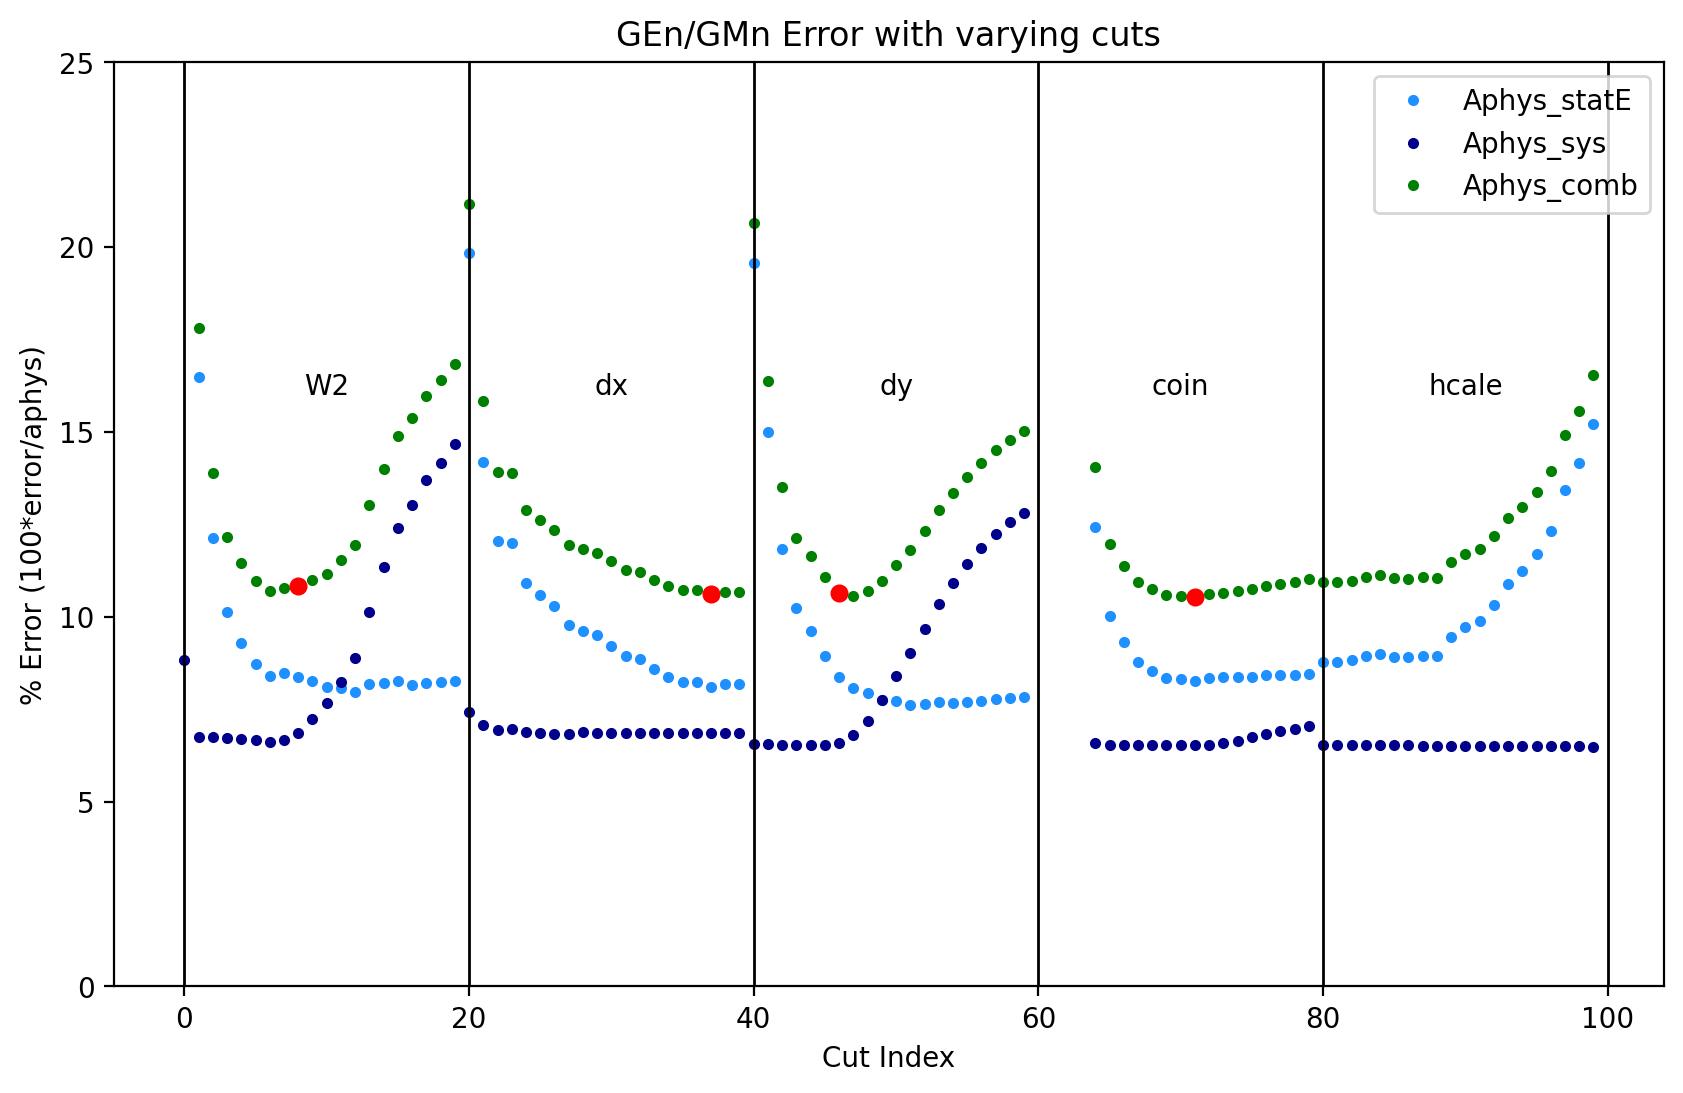

In [93]:
fig, ax1 = plt.subplots(figsize=(10,6), dpi=200)
msize = 11

# Plot aphys errors on the left y-axis
ax1.plot(cutindex, 100*np.array(genstat)/gen, '.', color='dodgerblue', label='Aphys_statE')
ax1.plot(cutindex, 100*np.array(gensys)/gen, '.', color='darkblue', label='Aphys_sys')
ax1.plot(cutindex, 100*(np.array(gensys)**2+np.array(genstat)**2)**(1/2)/gen, '.', color='green', label='Aphys_comb')

highlight_indices = [8, 17+stepsize, 6+2*stepsize, 7+3*stepsize]
for idx in highlight_indices:
    try:
        ax1.plot(cutindex[idx], 100*(np.array(gensys[idx])**2+np.array(genstat[idx])**2)**(1/2)/gen[idx], '.', color='red', markersize=msize)
       # ax1.plot(cutindex[idx], 100*np.array(gensys)[idx]/gen[idx], '.', color='red', markersize=msize)
    except: continue

ax1.set_ylabel("% Error (100*error/aphys)")
ax1.set_xlabel("Cut Index")
ax1.set_ylim(0, 25)
ax1.set_title("GEn/GMn Error with varying cuts")
ax1.axvline(0, color='black', linewidth=1)
ax1.axvline(stepsize, color='black', linewidth=1)
ax1.axvline(2*stepsize, color='black', linewidth=1)
ax1.axvline(3*stepsize, color='black', linewidth=1)
ax1.axvline(4*stepsize, color='black', linewidth=1)
ax1.axvline(5*stepsize, color='black', linewidth=1)

ax1.text(stepsize/2, 16, "W2", ha='center')
ax1.text(2*stepsize - stepsize/2, 16, "dx", ha='center')
ax1.text(3*stepsize - stepsize/2, 16, "dy", ha='center')
ax1.text(4*stepsize - stepsize/2, 16, "coin", ha='center')
ax1.text(5*stepsize - stepsize/2, 16, "hcale", ha='center')

# Create right y-axis
#ax2 = ax1.twinx()
#ax2.errorbar(cutindex, np.array(gen), gen_error, fmt='o', linestyle='none', color='black', label='GEn/GMn*muN',alpha=.1)
#ax2.set_ylabel("GEn/GMn*muN")  # Customize as needed
#ax2.set_ylim(0, 1)
#lines2, labels2 = ax2.get_legend_handles_labels()

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()

#ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax1.legend(lines1 , labels1 , loc='upper right')


(0.0, 0.4)

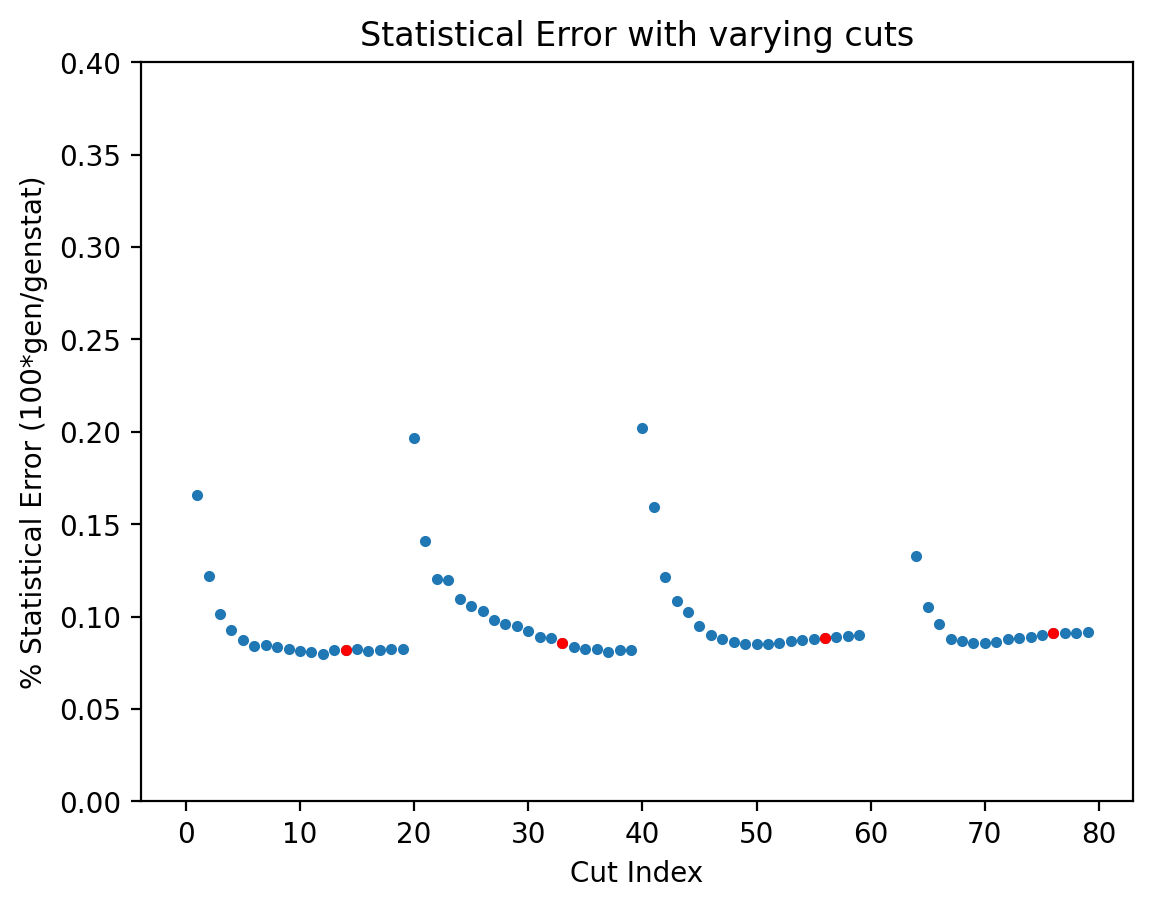

In [138]:
plt.figure(dpi=200)
plt.plot(cutindex,(np.array(genstat)/np.array(gen)),'.')
plt.plot(cutindex[14],(np.array(genstat)/np.array(gen))[14],'.',color='red')
plt.plot(cutindex[13+stepsize],(np.array(genstat)/np.array(gen))[13+stepsize],'.',color='red')
plt.plot(cutindex[16+2*stepsize],(np.array(genstat)/np.array(gen))[16+2*stepsize],'.',color='red')
plt.plot(cutindex[12+3*stepsize],(np.array(genstat)/np.array(gen))[12+3*stepsize],'.',color='red')
plt.ylabel("% Statistical Error (100*gen/genstat)")
plt.title("Statistical Error with varying cuts")
plt.xlabel("Cut Index")
plt.ylim(0,.4)

In [54]:
rel_contribs

{'f_acc': 0.0053727282421508335,
 'f_p': 0.011190666709856025,
 'f_inelastic': 0.028460170722720352,
 'f_N2': 0.014547505068825203,
 'A_acc': 0.1565443979000908,
 'A_p': 0.00011168871680368015,
 'A_inelastic': 0.14070328167944898,
 'P': 99.64306956096011}

In [55]:
GEGM=statdict['GE/GM * muN']
GEGMstat=statdict['GE/GM_stat_error']
GEGMsys=statdict['GE/GM_sys_error']

In [56]:
GEGME=np.sqrt(GEGMstat**2+GEGMsys**2)

In [57]:
GEN2Data = {
    'Q2': [Q2_avg],
    'ExpName': ['GEn-II'],
    'R': [GEGM ],
    'R_err': [GEGME],
    'GEn': [0],   # assuming GEn and GEn_err are present in the file
    'GEn_err': [0]
}

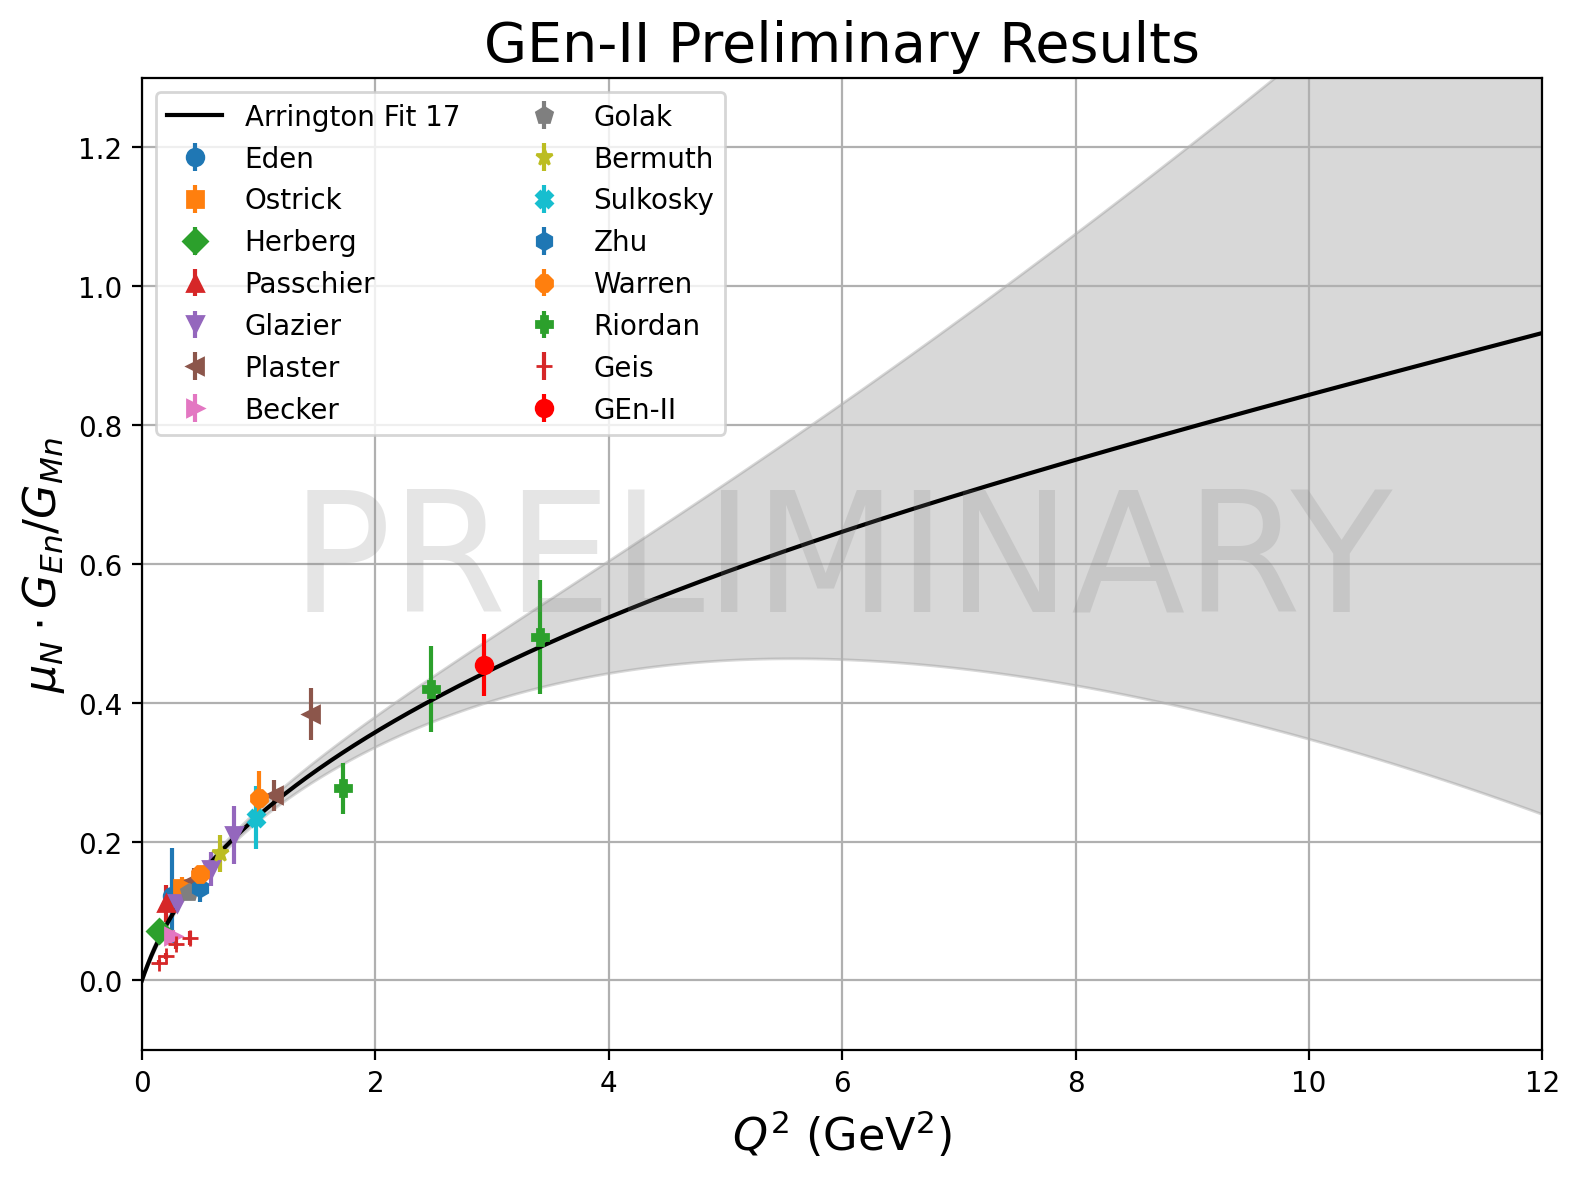

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GETFF import Function_GETFF  # Assuming you have this imported somewhere

# Load theory Q2 and GEn/GD ratio
GEntheory = np.transpose(np.loadtxt('../DB/neutron_lookup.dat'))
Q2t = np.sort(GEntheory[0])

# Calculate GE/GM and uncertainties using GETFF
GEGD, GEGDE, GMGD, GMGDE = [], [], [], []
for q2 in Q2t:
    GEGD.append(Function_GETFF(3, q2)[0])
    GEGDE.append(Function_GETFF(3, q2)[1])
    GMGD.append(Function_GETFF(4, q2)[0])
    GMGDE.append(Function_GETFF(4, q2)[1])

GEGD = np.array(GEGD)
GEGDE = np.array(GEGDE)
GMGD = np.array(GMGD)
GMGDE = np.array(GMGDE)

# Error propagation: GE/GM with uncertainty
def eprop(GE, GEE, GM, GMM):
    R = GE / GM
    fractional_error = np.sqrt((GEE / GE)**2 + (GMM / GM)**2)
    return R, R * fractional_error

RatFit, RatFitE = eprop(GEGD, GEGDE, GMGD, GMGDE)

# Load world data
df = pd.read_csv("../DB/GEn_World_Data.csv")
mu_n = 1.91

# Setup plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'h', '8', 'P', '+', 'x', '|', '_']
experiments = df["Experiment"].unique()
markers = {exp: marker_styles[i % len(marker_styles)] for i, exp in enumerate(experiments)}

# Plot world data
for exp in experiments:
    subset = df[df["Experiment"] == exp]
    ax.errorbar(subset["Q2"], mu_n * subset["GEn"] / subset["GMn"],
                subset["RatE"], fmt=markers[exp], label=exp)
plt.errorbar(GEN2Data['Q2'],GEN2Data['R'],GEN2Data['R_err'],fmt='o',color='red',label='GEn-II')

# Plot fit and shaded error band
ax.plot(Q2t, RatFit, color='black', label='Arrington Fit 17')
ax.fill_between(Q2t, RatFit - RatFitE, RatFit + RatFitE, color='gray', alpha=0.3)

# Watermark and labels
ax.text(0.5, 0.5, 'PRELIMINARY', fontsize=60, color='gray',
        ha='center', va='center', alpha=0.2, transform=ax.transAxes)

ax.set_xlim(0, 12)
ax.set_ylim(-0.1, 1.3)
ax.grid(True)
ax.set_xlabel('$Q^2$ (GeV$^2$)', fontsize=16)
ax.set_ylabel(r'$\mu_N \cdot G_{En} / G_{Mn}$', fontsize=16)
ax.set_title('GEn-II Preliminary Results', fontsize=20)
ax.legend(loc='upper left', fontsize=10, ncol=2)
#plt.yscale("log")
plt.tight_layout()
plt.savefig("PrelimResults.pdf")
plt.show()


In [34]:
with open("kin2results.txt",'w') as f:
    for i,key in enumerate(statdict):
        if i<4:
            f.write(key+","+f"{statdict[key]:.0f}\n")
        else:
            f.write(key+","+f"{statdict[key]:.4f}\n")